# Data Augmentation - Conditional Wasserstein GANs - GP

### Dataset: Grapevine Dataset

This notebook presents the CWGAN-GP model to generate treated Intensity Data from the experimental grapevine dataset.

Notebook Organization:
- Read the dataset
- Setup the CWGAN-GP model and train the model with grapevine intensity data
- Generate artificial samples in an artificial dataset and compare them to the experimental data
- Train 11 models each leaving three different samples of the experimental data leftover to use as a test set and see performance of supervised analysis
- Some of the optimizations made to the model


#### Needed Imports

In [1]:
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
from collections import namedtuple, Counter

from tqdm import tqdm
from IPython import display as ipythondisplay

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf
import os
from keras import backend

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse
import gan_evaluation_metrics as gem
import linear_augmentation_functions as laf

In [2]:
%matplotlib inline

Reading the data to be analysed and augmented

In [3]:
path = Path.cwd() / "store_data" / 'processed_data_GD.json'
storepath = Path.cwd() / "store_data" / 'processed_data_GD.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        for key in dataset:
            if 'iter_fold_splits' == key:
                continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
                    if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])] = {}
                    if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
                    if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]

                else:
                    dataset[key] = store[storekey]
                
            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value

Linear Augmentation / Interpolation of the experimental data and corresponding sample labels/classes to use as training data for the GAN network .

In [21]:
start = perf_counter()
data, lbls = laf.artificial_dataset_generator(datasets['vitis_types']['Ionly'], labels=datasets['vitis_types']['target'],
                                        max_new_samples_per_label=512, binary=False, rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=None, rnd_state=756)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 45.040 s


In [22]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
Leu_Enk_neg = 554.26202

# Normalization by a reference feature
norm = transf.normalize_ref_feature(data, Leu_Enk_neg, remove=True)
# Pareto Scaling and Generalized Logarithmic Transformation
NP = transf.pareto_scale(norm)
data_NGP = transf.pareto_scale(transf.glog(norm, lamb=None))

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)


### Obtaining Inputs for GAN model

In [23]:
# Requires Linear Augmentation of Data to be ran first to generate these files
dist_results_real = np.load('store_data/dist_results_real.npy',allow_pickle='TRUE').item()
dist_results_generated = np.load('store_data/dist_results_generated.npy',allow_pickle='TRUE').item()

In [24]:
# Get distribution of intensity values of the dataset
hist = np.histogram(datasets['vitis_types']['NGP'].values.flatten(), bins=100)
input_realdata_dist = stats.rv_histogram(hist)

In [25]:
# Separate parts of parameters
shapes = dist_results_real['norminvgauss']['parameters'][:-2]
loc = dist_results_real['norminvgauss']['parameters'][-2]
scale = dist_results_real['norminvgauss']['parameters'][-1]
input_norminvgaussy_dist = stats.norminvgauss(a=shapes[0], b=shapes[1], loc=loc, scale=scale)

Set up colours for each of the classes. Generated samples will have the corresponding label with 'gen_' from generated before them.

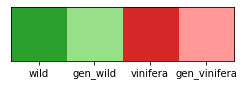

In [26]:
colours2 = sns.color_palette('tab20', 10)[4:8]

ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

## Conditional Wasserstein GAN - GP model

This model construction was made by joining WGAN-GP models with Conditional GAN models. WGAN-GP models were originally made according to / originally based in https://keras.io/examples/generative/wgan_gp/#wasserstein-gan-wgan-with-gradient-penalty-gp and Conditional GAN models - https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ (generator and discriminator model) and https://keras.io/examples/generative/conditional_gan/ without using OOP (loss functions and training/training steps).

In [27]:
# Import needed functions from GAN_functions
#from GAN_functions import wasserstein_loss
from GAN_functions import gradient_penalty_cwgan
from GAN_functions import critic_loss_wgan
from GAN_functions import generator_loss_wgan

In [28]:
batch_size = 32

all_data = data_NGP.iloc[np.random.RandomState(seed=145).permutation(len(data_NGP))]/(2*data_NGP.values.std())
#test.shuffle(buffer_size=len(test), seed=145)#.batch(batch_size)
true_labels = pd.get_dummies(np.array(lbls)[np.random.RandomState(seed=145).permutation(len(data_NGP))]).values[:,0]

Functions for the generator and critic (discriminator) models

In [29]:
def generator_model(len_input, len_output, n_hidden_nodes, n_labels): 
    "Make the generator model of CWGAN-GP."

    data_input = tf.keras.Input(shape=(len_input,), name='data') # Take intensity input
    label_input = tf.keras.Input(shape=(1,), name='label') # Take Label Input
    
    # Treat label input to concatenate to intensity data after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m2 = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m2]) # Concatenate intensity and label data
    # Hidden Dense Layer and Normalization
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.BatchNormalization()(joined_data)
    
    # Output - number of features of sample to make
    output = tf.keras.layers.Dense(len_output, activation='linear', use_bias=True)(joined_data)
    
    generator = tf.keras.Model(inputs=[data_input, label_input], outputs=output)
    
    return generator


def critic_model(len_input, n_hidden_nodes, n_labels):
    "Make the critic model of CWGAN-GP."
    
    label_input = tf.keras.Input(shape=(1,)) # Take intensity input
    data_input = tf.keras.Input(shape=(len_input,)) # Take Label Input

    # Treat label input to concatenate to intensity data after
    label_m = tf.keras.layers.Embedding(n_labels, 30, input_length=1)(label_input)
    label_m = tf.keras.layers.Dense(256, activation='linear', use_bias=True)(label_m)
    #label_m = tf.keras.layers.Reshape((len_input,1,))(label_m)
    label_m = tf.keras.layers.Reshape((256,))(label_m)

    joined_data = tf.keras.layers.Concatenate()([data_input, label_m]) # Concatenate intensity and label data
    # Hidden Dense Layer (Normalization worsened results here)
    joined_data = tf.keras.layers.Dense(n_hidden_nodes, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    joined_data = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True)(joined_data)
    #joined_data = tf.keras.layers.BatchNormalization()(joined_data)

    # Output Layer - 1 node for critic decision
    output = tf.keras.layers.Dense(1, activation='linear', use_bias=True)(joined_data)
    
    critic = tf.keras.Model(inputs=[data_input, label_input], outputs=output)

    return critic

In [30]:
# To save the models built
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [31]:
def generate_predictions(model, num_examples_to_generate, len_input, input_dist, uni_lbls):
    "Generate sample predictions based on a Generator model."
    
    test_input =  tf.constant(input_dist.rvs(size=len_input*num_examples_to_generate), shape=[
        num_examples_to_generate,len_input]) 
    
    if len(uni_lbls) < 3:
        test_labels = tf.constant([1.0]*(num_examples_to_generate//2) + [0.0]*(num_examples_to_generate//2), 
                                  shape=(num_examples_to_generate,1))
    else:
        test_labels = []
        for i in range(len(uni_lbls)):
            test_labels.extend([i]*(num_examples_to_generate//len(uni_lbls)))
        test_labels = np.array(pd.get_dummies(test_labels))
        #np.array(pd.get_dummies([i for i in range(len(uni_lbls))]*(num_examples_to_generate//len(uni_lbls))))
    predictions = model([test_input, test_labels], training=False) # `training` is set to False.
    return predictions

In [32]:
def training_montage(train_data_o, train_lbls, test_data, test_lbls,
                     epochs, generator, critic, generator_optimizer, critic_optimizer, input_dist,
                    batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15):
    """Train a generator and critic of CWGAN-GP.
    
       Receives training data and respective class labels (train_data_o and train_lbls) and trains a generator and a critic
    model (generator, critic) over a number of epochs (epochs) with a set batch size (batch_size) with the respective 
    optimizers and learning rate (generator_optimizer, critic_optimizer). Gradient Penalty is calculated with grad_pen_weight
    as the weight of the penalty.
       The functions returns at time intervals three graphs to evaluate the progression of the models (Loss plots, coverage,
    density, crossLID and correct first cluster plots and PCA plot with generated and test data). To this end, samples need
    to be generated requiring the distribution to sample the initial input values from (input_dist), and test data and
    respective labels has to be given (test_data and test_lbls). Finally the number of neighbors to consider for 
    coverage/density and crossLID calculation is also needed (k_cov_den, k_crossLID).
    
       train_data_o: Pandas DataFrame with training data;
       train_lbls: List with training data class labels;
       test_data: Pandas DataFrame with test data to evaluate the model;
       test_lbls: List with test data class labels to evaluate the model;
       epochs: Int value with the number of epochs to train the model;
       generator: tensorflow keras.engine.functional.Functional model for the generator;
       critic: tensorflow keras.engine.functional.Functional model for the critic;
       generator_optimizer: tensorflow keras optimizer (with learning rate) for generator;
       critic_optimizer: tensorflow keras optimizer (with learning rate) for critic;
       input_dist: scipy.stats._continuous_distns.rv_histogram object - distribution to sample input values for generator;
       batch_size: int value with size of batch for model training;
       grad_pen_weight: int value (default 10) for penalty weight in gradient penalty calculation;
       k_cov_den: int value (default 50) for number of neighbors to consider for coverage and density calculation in generated
    samples evaluation;
       k_crossLID: int value (default 15) for number of neighbors to consider for crossLID calculation in generated samples
    evaluation.
    """
    
    # Obtaining the train data, randomize its order and divide it be twice the standard deviation of its values
    all_data = train_data_o.iloc[
        np.random.RandomState(seed=145).permutation(len(train_data_o))]/(2*train_data_o.values.std())
    
    # Same treatment for the test data
    test_data = (test_data/(2*test_data.values.std())).values
    training_data = all_data
    train_data = all_data.values
    
    # Change class labels to numerical values while following the randomized ordered of samples
    if len(set(train_lbls)) < 3: # 1 and 0 for when there are only two classes
        train_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data))]).values[:,0]
        test_labels = pd.get_dummies(np.array(test_lbls)).values[:,0]
    else: # One hot encoding for when there are more than two classes
        train_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data))]).values
        test_labels = pd.get_dummies(np.array(test_lbls)).values
    # Save the order of the labels
    ordered_labels = pd.get_dummies(
            np.array(train_lbls)[np.random.RandomState(seed=145).permutation(len(train_data_o))]).columns
    
    # To save the model after
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     critic_optimizer=critic_optimizer,
                                     generator=generator,
                                     critic=critic)

    batch_divisions = int(batch_size / len(set(train_lbls))) # See how many samples of each class will be in each batch
    n_steps = epochs * int(training_data.shape[0] / batch_size) # Number of steps: nº of batches per epoch * nº of epochs
    n_critic = 5
    
    # Set up the evaluating images printed during training and the intervals they will be updated
    f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))
    update1 = n_steps//200
    update2 = n_steps//20

    if hasattr(tqdm, '_instances'):
        tqdm._instances.clear() # clear if it exists

    i=0

    for step in tqdm(range(n_steps)):
        
        # Critic Training
        crit_loss_temp = []
        
        # Select real samples for this batch on training and order samples to put samples of the same class together
        real_samp = train_data[i*batch_size:(i+1)*batch_size]
        real_lbls = train_labels[i*batch_size:(i+1)*batch_size]

        real_samples = np.empty(real_samp.shape)
        real_labels = np.empty(real_lbls.shape)
        a = 0
        if len(set(train_lbls)) < 3:
            for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: pair[0], reverse=True):
                real_samples[a] = s
                real_labels[a] = l
                a = a+1
        else:
            for l,s in sorted(zip(real_lbls, real_samp), key=lambda pair: np.argmax(pair[0]), reverse=False):
                #print(l, np.argmax(l))
                real_samples[a] = s
                real_labels[a] = l
                a = a+1
        
        #ones = np.count_nonzero(real_labels == 1)
        #zeros = np.count_nonzero(real_labels == 0)

        for _ in range(n_critic): # For each step, train critic n_critic times
            
            # Generate input for generator
            artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
            artificial_labels = real_labels.copy()

            # Generate artificial samples from the latent vector
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            #print(real_labels.shape)
            
            with tf.GradientTape() as crit_tape: # See the gradient for the critic

                # Get the logits for the generated samples
                X_artificial = critic([artificial_samples, artificial_labels], training=True)
                # Get the logits for the real samples
                X_true = critic([real_samples, real_labels], training=True)

                # Calculate the critic loss using the generated and real sample results
                c_cost = critic_loss_wgan(X_true, X_artificial)

                # Calculate the gradient penalty
                grad_pen = gradient_penalty_cwgan(batch_size, real_samples, artificial_samples,
                                                  real_labels, artificial_labels, critic)
                # Add the gradient penalty to the original discriminator loss
                crit_loss = c_cost + grad_pen * grad_pen_weight
                #print(crit_loss)
                #crit_loss = c_cost
                
            crit_loss_temp.append(crit_loss)

            # Calculate and apply the gradients obtained from the loss on the trainable variables
            gradients_of_critic = crit_tape.gradient(crit_loss, critic.trainable_variables)
            #print(gradients_of_critic)
            critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

        i = i + 1
        if (step+1) % (n_steps//epochs) == 0:
            i=0

        crit_loss_all.append(np.mean(crit_loss_temp))
        
        # Generator Training
        # Generate inputs for generator, values and labels
        artificial_samples = tf.constant(input_dist.rvs(size=all_data.shape[1]*batch_size), shape=[
                batch_size,all_data.shape[1]])
        
        if len(set(train_lbls)) < 3:
            artificial_labels = tf.constant([1.0]*(batch_size//2) + [0.0]*(batch_size//2), shape=(batch_size,1))
        else:
            artificial_labels = np.array(pd.get_dummies([i for i in range(len(set(train_lbls)))]*batch_divisions))
    
        with tf.GradientTape() as gen_tape: # See the gradient for the generator
            # Generate artificial samples
            artificial_samples = generator([artificial_samples, artificial_labels], training=True)
            
            # Get the critic results for generated samples
            X_artificial = critic([artificial_samples, artificial_labels], training=True)
            # Calculate the generator loss
            gen_loss = generator_loss_wgan(X_artificial)

        # Calculate and apply the gradients obtained from the loss on the trainable variables
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #print(gradients_of_generator)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gen_loss_all.append(gen_loss)

        # Update the progress bar and evaluation graphs every update1 steps for loss plots and update2 for the others.
        if (step + 1) % update1 == 0:
            
            # Update the evaluating figures at the set intervals
            axl.clear() # Always clear the corresponding ax before redrawing it
            
            # Loss Plot
            axl.plot(gen_loss_all, color = 'blue', label='Generator Loss')
            axl.plot(crit_loss_all,color = 'red', label='Critic Loss')
            axl.set_xlabel('Number of Steps')
            axl.set_ylabel('Loss')
            axl.legend()
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        if (step + 1) % update2 == 0:

            saved_predictions.append(generate_predictions(generator, 96, all_data.shape[1], 
                                                          input_realdata_dist, ordered_labels))
            # See density and coverage and crossLID (divided by 50 to be in the same order as the rest) of latest predictions
            den, cov = gem.evaluation_coverage_density(test_data, saved_predictions[-1], k= k_cov_den, metric='euclidean')
            clid = gem.cross_LID_estimator_byMLE(test_data, saved_predictions[-1], k=k_crossLID, metric='euclidean')/50
            density.append(den)
            coverage.append(cov)
            crossLID.append(clid)

            # PCA of the latest predictions and training data
            # Divide by twice the standard deviation to be the same as the generated data
            dfs_temp = pd.concat((train_data_o/(2*train_data_o.values.std()),pd.DataFrame(
                saved_predictions[-1].numpy(), columns=train_data_o.columns))) 
            temp_lbls = train_lbls.copy()
            for l in ordered_labels:
                temp_lbls.extend(['gen_'+l]*(96//len(ordered_labels)))
            principaldf = gem.pca_sample_projection(dfs_temp, temp_lbls, pca, whiten=True, 
                                                samp_number=len(train_data_o.index))
            lcolors = label_colors_test

            # Hierarchical clustering of the latest predictions and testing data, 
            # saving the correct 1st cluster fraction results
            dfs_temp = np.concatenate((test_data, saved_predictions[-1].numpy()))
            temp_lbls = ['real']*len(test_data) + ['gen']*len(saved_predictions[-1])
            hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='average')
            corr1stcluster.append(hca_results['correct 1st clustering'])
            
            # Plots
            axc.clear()
            axc.plot(range(update2, step+2, update2), coverage, label='coverage')
            axc.plot(range(update2, step+2, update2), density, label='density')
            axc.plot(range(update2, step+2, update2), crossLID, color='red', label='crossLID')
            axc.plot(range(update2, step+2, update2), corr1stcluster, color='purple', label='corr_cluster')
            axc.legend()

            axr.clear()
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
            axr.legend(loc='upper right', ncol=1, framealpha=1)
            
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
        # Save the model every so often
        if (step + 1) % (update2*5) == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)      

In [33]:
df = datasets['vitis_types']['NGP']
pca = PCA(n_components=2, svd_solver='full', whiten=True)
pc_coords = pca.fit_transform(df)

### Plot the models

In [34]:
generator = generator_model(data_NGP.shape[1], data_NGP.shape[1], 256, 2)
critic = critic_model(data_NGP.shape[1], 512, 2)

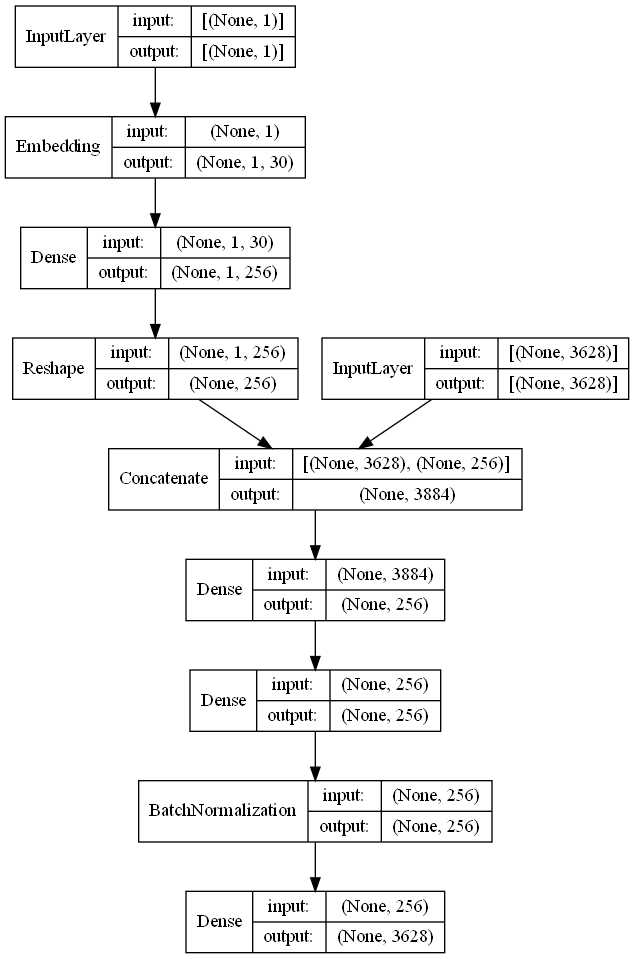

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=False)

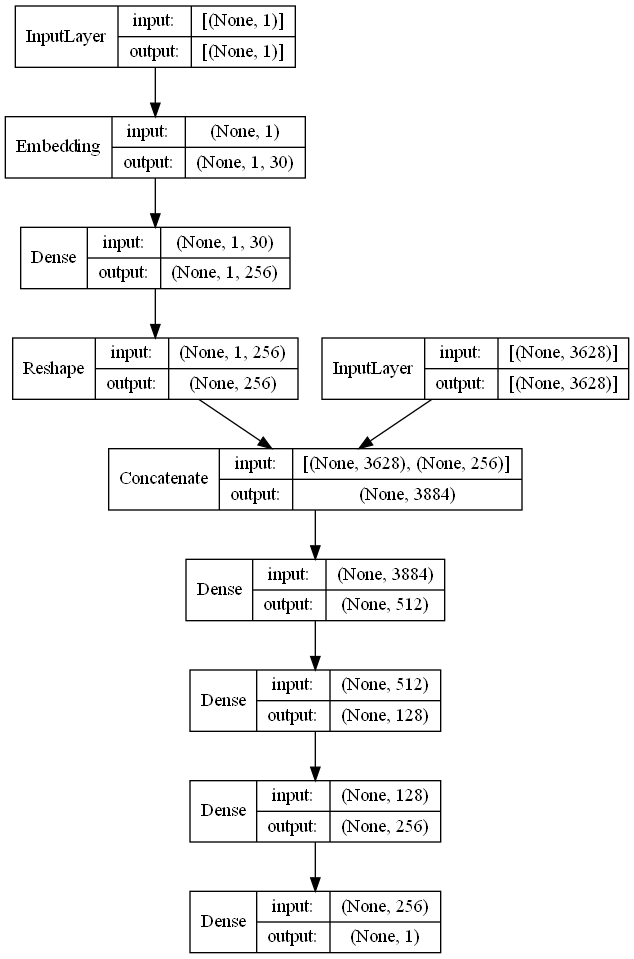

In [36]:
plot_model(critic, to_file='critic_plot.png', show_shapes=True, show_layer_names=False)

### Training the GAN

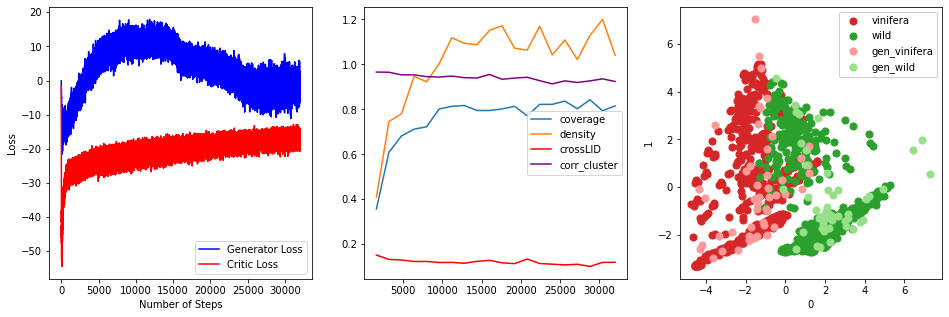

100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [3:23:32<00:00,  2.62it/s]


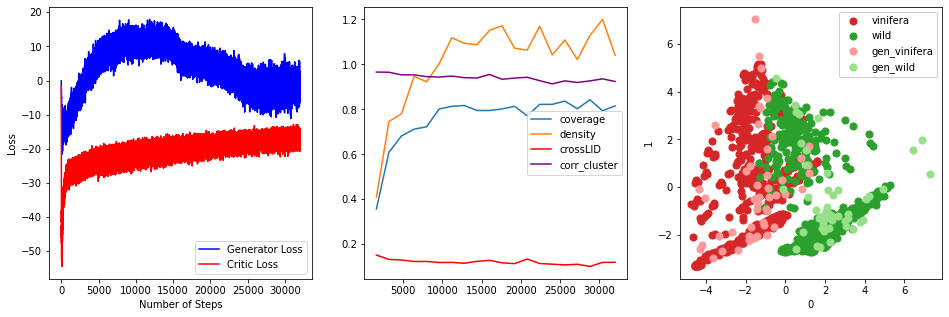

In [37]:
GENERATE=True
if GENERATE:
    # Store results
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

    generator = generator_model(data_NGP.shape[1], data_NGP.shape[1], 256, 2)
    critic = critic_model(data_NGP.shape[1], 512, 2)

    training_montage(data_NGP, lbls, data_NGP, lbls, 1000, generator, critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

    #    results[i]={'gen_loss': gen_loss_all, 'crit_loss1': crit_loss1_all, 'crit_loss2': crit_loss2_all,
    #                'saved_pred': saved_predictions,
    #                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [38]:
import csv
#GENERATE = False
if GENERATE:
    # Save the generator and critic models' weights.
    generator.save_weights('gan_models/GD_gen')
    critic.save_weights('gan_models/GD_crit')
    
    with open('gan_models/bin_GD_results.csv', 'w') as csvfile:
        results={'gen_loss': [i.numpy() for i in gen_loss_all], 'crit_loss': crit_loss_all,
                    'saved_pred': [i.numpy() for i in saved_predictions],
                    'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}
        writer = csv.DictWriter(csvfile, fieldnames=results.keys())
        writer.writeheader()
        writer.writerow(results)
else:
    # Read back the saved model
    generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

    generator = generator_model(data_NGP.shape[1], data_NGP.shape[1], 256, 2)
    critic = critic_model(data_NGP.shape[1], 512, 2)

    # Load Previously saved models
    generator.load_weights('./gan_models/GD_gen')
    critic.load_weights('./gan_models/GD_crit')
    
    #results = pd.read_csv('gan_models/bin_HD_results.csv').to_dict()

#### Generate examples from our new code


- Generate examples in bulk - predictions (GAN data)
- Select only the 5 most correlated generated samples with each of the original samples - corr_preds (CorrGAN Data)

In [39]:
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=data_NGP.shape[1]*num_examples_to_generate), 
                         shape=[num_examples_to_generate, data_NGP.shape[1]])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions = pd.DataFrame(predictions.numpy(), columns=data_NGP.columns)
predictions

test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,])

See correlation between samples and choose the 5 most correlated generated samples for each of the original samples.

In [40]:
df = datasets['vitis_types']['NGP']
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=predictions.index, columns=df.index).astype('float')

for i in df.index:
    for j in predictions.index:
        correlations.loc[j,i] = stats.pearsonr(df.loc[i],
                                               predictions.loc[j])[0]

In [41]:
# Indices to keep in the correlated GAN data
idx_to_keep = []
for i in correlations:
    idx_to_keep.extend(correlations[i].sort_values(ascending=False).index[:5])
    
print('Nº of total idx :', len(idx_to_keep))
print('Nº of unique idx:', len(set(idx_to_keep)))

Nº of total idx : 165
Nº of unique idx: 164


In [42]:
# Make the correlation GAN dataframe and corresponding label targets
corr_preds = predictions.loc[list(set(idx_to_keep))]
corr_lbls  = list(np.array(test_labels)[list(set(idx_to_keep))])

In [43]:
# Redo prediction with a smaller number of samples this time
num_examples_to_generate = 1024
test_input = tf.constant(input_realdata_dist.rvs(size=data_NGP.shape[1]*num_examples_to_generate), 
                         shape=[num_examples_to_generate, data_NGP.shape[1]])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])

predictions = generator([test_input, test_labels], training=False)
predictions

test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,])

In [44]:
critic([predictions, test_labels])

<tf.Tensor: shape=(1024, 1), dtype=float32, numpy=
array([[ 13.536467 ],
       [ 14.945339 ],
       [-10.478966 ],
       ...,
       [ -7.0644855],
       [  4.1810536],
       [-12.809178 ]], dtype=float32)>

In [45]:
predictions = pd.DataFrame(predictions.numpy(), columns=data_NGP.columns)

### Inducing noise on Feature Occurrence Data and imputing intensity values Method Sample Generation

In [46]:
# Generating Linearly Interpolated Feature Occurrence Data
start = perf_counter()
data_bin, lbls_bin = laf.artificial_dataset_generator(datasets['vitis_types']['BinSim'], labels=datasets['vitis_types'][
    'target'], max_new_samples_per_label=768, binary='random sampling', rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=314, rnd_state=341)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 188.208 s


In [47]:
# Inducing noise on linearly interpolated feature occurrence data
noise_df = data_bin.copy()
for i in tqdm(range(len(data_bin.index))):
    if lbls_bin[i] == 'wild':
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='wild'])
    else:
        noise_df.iloc[i] = laf.imbalanced_noise_inducer(
            data_bin.iloc[i], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
            data = datasets['vitis_types']['BinSim'].loc[np.array(datasets['vitis_types']['target'])=='vinifera'])

100%|█████████████████████████████████████████████████████████████████████████████| 1536/1536 [00:07<00:00, 193.25it/s]


In [48]:
# Function to impute intensity values
def impute_intensity_values(df_bin, orig_data, labels=None, orig_labels=None):
    """From a binary dataframe impute intensities and missing values in 1 and 0 values, respectively.
       
       This is done according to the distributions of intensity in an original reference dataset.
       
       df_bin: Pandas DataFrame; data with binary data
       orig_data: Pandas DataFrame; original data with intensity
       labels: list; list of labels for each sample in the binary data; if None, the label '' is give to every sample
       orig_labels: list; list of labels for each samples in the original data with intensity; if None, the label '' is 
    give to every sample

       returns: Pandas DataFrame; binary dataset imputed with intensity values
       """
    df_int = pd.DataFrame(columns=df_bin.columns, index=df_bin.index)
    if labels == None:
        labels = ['']*len(df_bin)
        orig_labels = ['']*len(orig_data)

    df_int = pd.DataFrame(columns=df_bin.columns, index=df_bin.index) # DataFrame to put the intensity values
    
    # For each different class in the dataset
    for lbl in set(labels):
        
        df_orig = orig_data[[i==lbl for i in orig_labels]] # Reduce dataframe to samples of a label

        flat_values = df_orig.values.flatten() # Get the distribution of values of intensity in that label
        flat_values_red = np.log(flat_values[~np.isnan(flat_values)]) # Logarithmic distribution
        
        for i in df_bin[[i==lbl for i in labels]].columns:
            # See if the feature appears at least one time in the artificial dataset for the class of the aritificial sample
            if df_bin[[i==lbl for i in labels]][i].sum() == 0:
                continue

            # If a feature has different minimum and maximum (appears more than 1) in the real samples of the class
            if df_orig[i].notnull().sum() > 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*(maxi-mini)
                #print(i, mini, maxi, dif)
            
            # If a feature has the same minimum and maximum (appears only once) in the real samples of the class
            elif df_orig[i].notnull().sum() == 1:
                mini = np.log(df_orig[i]).min()
                maxi = np.log(df_orig[i]).max()
                dif = 0.15*maxi
                #print(i, 1, mini,maxi,dif)
            
            # If a feature does not appear in the real samples of the class
            elif df_orig[i].notnull().sum() == 0:
                mini = np.log(df_orig).min().min()
                #maxi = np.log(df_orig).max().max()
                maxi = np.median(flat_values_red)
                dif = 0
                #print(i, 0, mini,maxi,dif)
            
            #print(i, mini, maxi)
            # Truncate the histogram values based on the minimum and maximum (and allowed extra margin)
            hist_values = flat_values_red[np.where((flat_values_red > mini-abs(dif)) & (flat_values_red < maxi+abs(dif)))]

            hist = np.histogram(hist_values, bins=50, density=True)
            prob_dist = stats.rv_histogram(hist)
            
            # Impute the intensity values for the needed samples for one feature
            for j in df_bin[[i==lbl for i in labels]].index:
                if df_bin.loc[j,i] == 1:
                    df_int.loc[j,i] = np.exp(prob_dist.rvs()) # Revert the logarithmic transformation
                    
    return df_int

In [49]:
# Dropping the leucine enkephalin peak
res = noise_df.drop(columns=['554.26202'])
# Normalize the real dataset before imputation and change the columns to be equal to our noise induced data
norm = transf.normalize_ref_feature(datasets['vitis_types']['data'], 554.26202, remove=True)
norm.columns = [str(i) for i in norm.columns]

# Impute intensity values
int_noise_df = impute_intensity_values(res, norm,
                    labels=lbls_bin, orig_labels=datasets['vitis_types']['target'])

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)


In [50]:
# Data Pre-treatment of the noise induced data without normalization since it was already imputed from normalized data
imputed = transf.fillna_frac_min_feature(int_noise_df, fraction=0.2)
#imputed = transf.fillna_frac_min(imputed, fraction=0.5)
int_noise_df = transf.pareto_scale(transf.glog(imputed.astype(float)))
int_noise_lbls = lbls_bin
int_noise_df

,97.2482,97.5887,97.588885,97.590015,97.5902,97.59094999999999,97.59188,97.72991999999999,98.153385,98.195875,...,966.00612,966.0547300000001,966.0576149999999,966.0663999999999,966.138205,966.140155,966.14212,966.1445,966.245005,977.114775
"Arti ('CS', 30)-('REG', 40)_rnd0.9",-0.259634,-1.000004,2.969348,-0.662784,2.069848,-0.328376,1.636660,-0.188867,-0.232372,-0.233097,...,4.580221,-0.288513,-0.289088,-0.298703,-0.264189,3.673568,-0.313153,2.753252,-0.353547,-0.275956
"Arti ('CS', 29)-('PN', 25)_rnd0.3",-0.259634,-1.000004,3.104182,-0.662784,2.246418,4.162719,1.670539,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,3.017113,-0.298703,-0.264189,-0.246612,-0.313153,2.767242,-0.353547,-0.275956
"Arti ('REG', 39)-('RL', 26)_rnd0.6",-0.259634,1.597192,-1.324812,2.434124,-0.996283,-0.328376,1.671698,-0.188867,-0.232372,-0.233097,...,-0.223830,3.692385,-0.289088,-0.298703,-0.264189,-0.246612,-0.313153,-0.441061,2.522221,3.790642
"Arti ('CS', 31)-('REG', 39)_rnd0.8",-0.259634,0.865704,2.779408,1.841253,2.388159,-0.328376,1.352885,-0.188867,-0.232372,-0.233097,...,-0.223830,3.874089,-0.289088,-0.298703,-0.264189,-0.246612,3.423614,-0.441061,-0.353547,-0.275956
"Arti ('CS', 30)-('TRI', 32)_rnd0.9",-0.259634,-1.000004,-1.324812,-0.662784,-0.996283,-0.328376,1.811264,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,-0.289088,-0.298703,-0.264189,-0.246612,-0.313153,2.762929,-0.353547,-0.275956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', 22)-('SYL', 11)_rnd0.1",2.925762,-1.000004,2.292499,-0.662784,2.351617,-0.328376,1.783467,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,-0.289088,-0.298703,-0.264189,-0.246612,-0.313153,-0.441061,-0.353547,-0.275956
"Arti ('RIP', 18)-('RU', 35)_rnd0.1",2.835909,0.935869,-1.324812,-0.662784,-0.996283,-0.328376,1.569263,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,3.346054,-0.298703,-0.264189,-0.246612,-0.313153,-0.441061,2.551180,-0.275956
"Arti ('LAB', 10)-('SYL', 12)_rnd0.5",-0.259634,-1.000004,1.789300,-0.662784,2.017194,-0.328376,1.075050,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,-0.289088,-0.298703,4.210785,-0.246612,-0.313153,-0.441061,-0.353547,-0.275956
"Arti ('CAN', 16)-('ROT', 20)_rnd0.3",-0.259634,-1.000004,-1.324812,-0.662784,1.659549,-0.328376,-1.741892,-0.188867,-0.232372,-0.233097,...,-0.223830,-0.288513,-0.289088,-0.298703,-0.264189,-0.246612,-0.313153,-0.441061,-0.353547,-0.275956


### Loss Plot and PCAs and tSNEs representation on the evolution of generated samples with epochs

Measures of progression of the model in time.

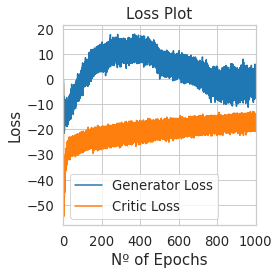

In [52]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        steps_per_epoch = int(data_NGP.shape[0] / batch_size)
        f, ax = plt.subplots(1, 1, figsize=(4,4))
        ax.plot(range(1,len(gen_loss_all)+1), gen_loss_all, label='Generator Loss')
        ax.plot(range(1,len(crit_loss_all)+1), crit_loss_all, label='Critic Loss')
        ax.set_xticks(range(0, 1001*steps_per_epoch, 200*steps_per_epoch))
        ax.set_xticklabels(range(0, 1001, 200))

        ax.legend()
        ax.set_xlim([0*steps_per_epoch,1000*steps_per_epoch])
        ax.set_xlabel('Nº of Epochs', fontsize=15)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_title('Loss Plot', fontsize=15)
        plt.tight_layout()
        f.savefig('images/GD_LossPlot.png' , dpi=300)

In [53]:
# Transform predictions into Pandas DataFrames
for i in range(len(saved_predictions)):
    saved_predictions[i] = pd.DataFrame(saved_predictions[i].numpy(), columns=data_NGP.columns)

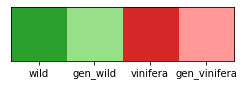

In [54]:
sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

**PCA and tSNE of GAN generated data and the linearly generated 'test data'**

Progression with number of epochs.

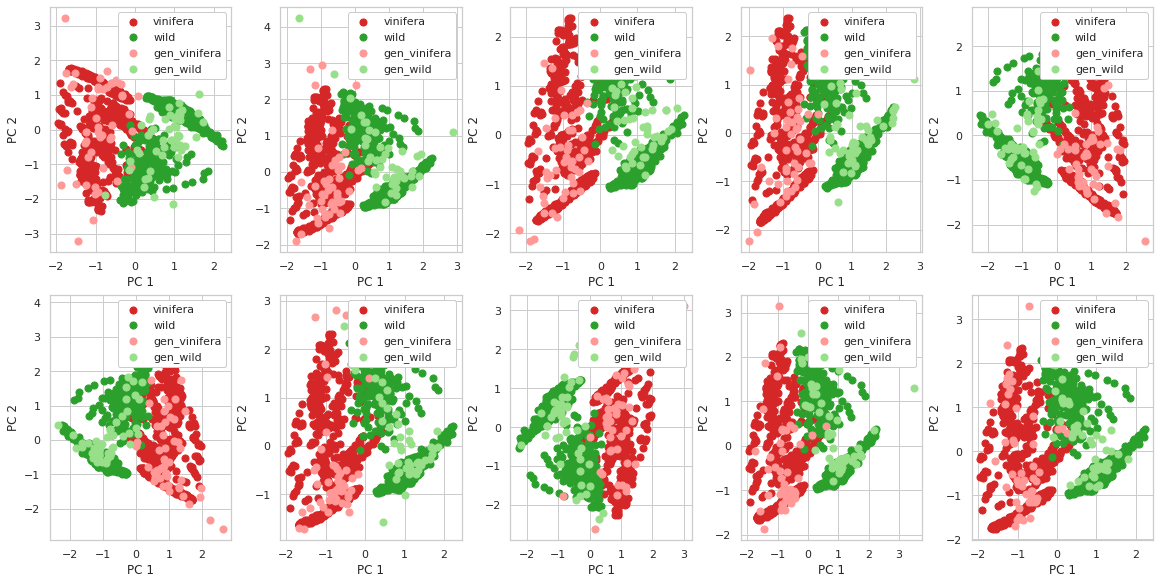

In [55]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            dfs_temp = pd.concat((data_NGP/(2*data_NGP.values.std()), saved_predictions[i]))
            temp_lbls = lbls.copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

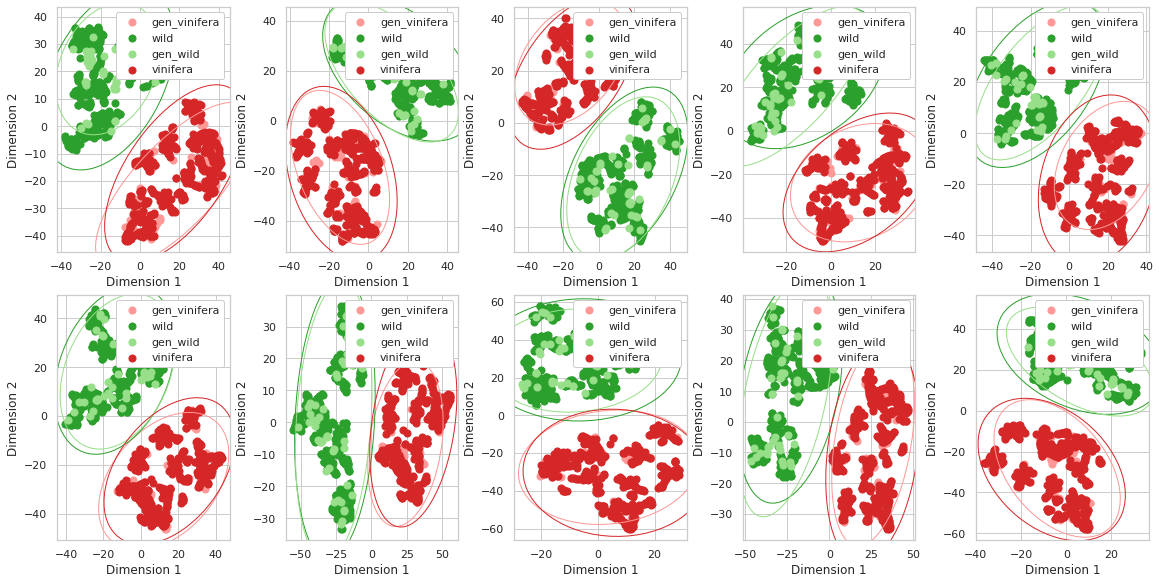

In [56]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            dfs_temp = pd.concat((data_NGP/(2*data_NGP.values.std()), saved_predictions[i]))
            temp_lbls = lbls.copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

**PCA and tSNE of GAN generated data and real data**

Progression with number of epochs.

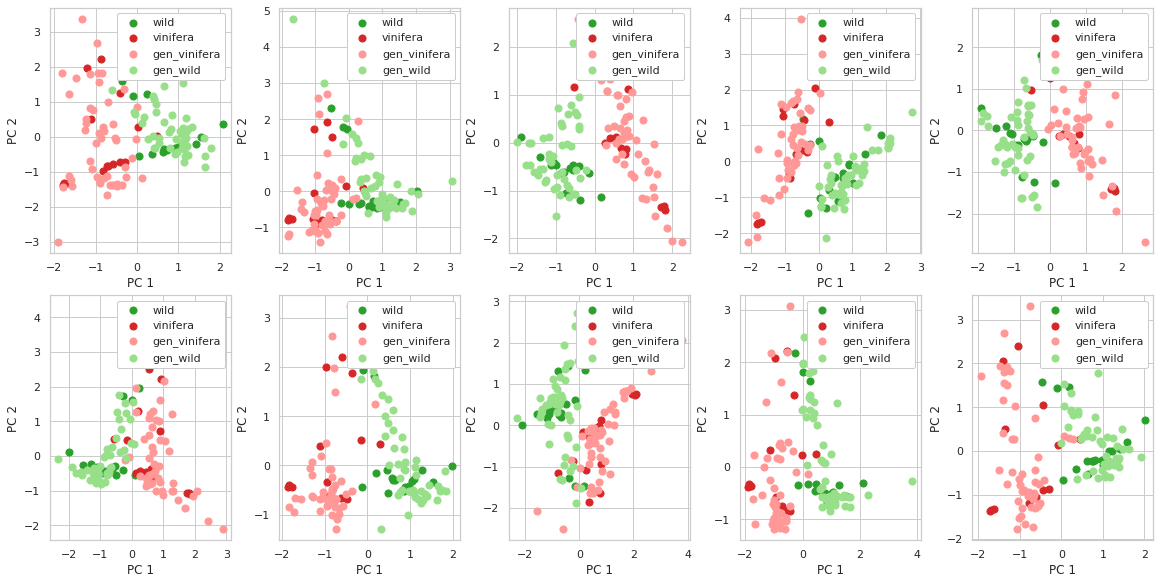

In [57]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions),2), axs.ravel()):
            p = saved_predictions[i].copy()
            p.columns = datasets['vitis_types']['NGP'].columns
            dfs_temp = pd.concat((datasets['vitis_types']['NGP']/(2*datasets['vitis_types']['NGP'].values.std()),
                                  p))
            temp_lbls = datasets['vitis_types']['target'].copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

            lcolors = label_colors_test
            
            gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            #gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)
        

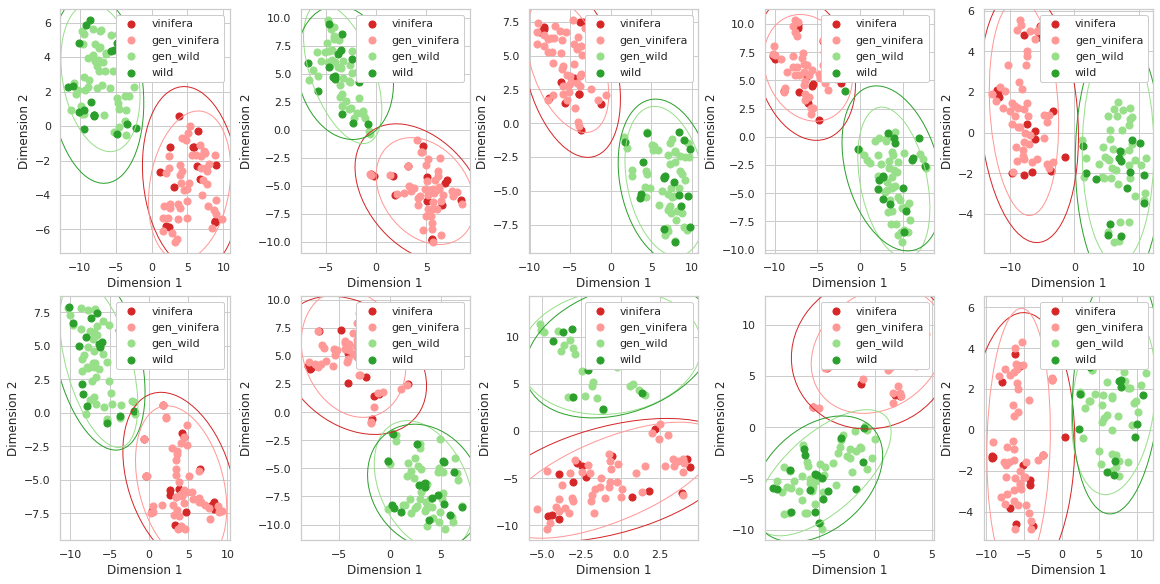

In [58]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(2,5, figsize=(16,8), constrained_layout=True)
        
        for i, ax in zip(range(0, len(saved_predictions), 2), axs.ravel()):
            
            p = saved_predictions[i].copy()
            p.columns = datasets['vitis_types']['NGP'].columns
            dfs_temp = pd.concat((datasets['vitis_types']['NGP']/(2*datasets['vitis_types']['NGP'].values.std()), p))
            temp_lbls = datasets['vitis_types']['target'].copy()
            temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
            temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))
            
            X = dfs_temp.copy()
            X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                              init='random', verbose=0).fit_transform(X)

            df = X_embedded
            labels = temp_lbls
            lcolors = label_colors_test
            
            gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=ax)
            gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=ax, q=0.95)
            ax.legend(loc='upper right', ncol=1, framealpha=1)

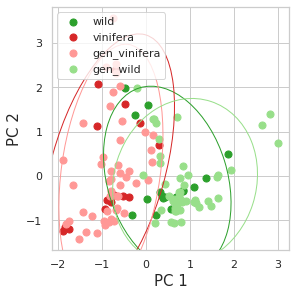

In [59]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
            
        p = saved_predictions[-1].copy()*(2*data_NGP.values.std())
        p.columns = datasets['vitis_types']['NGP'].columns
        dfs_temp = pd.concat((datasets['vitis_types']['NGP'], p))
        temp_lbls = datasets['vitis_types']['target'].copy()
        temp_lbls.extend(['gen_vinifera']*(len(saved_predictions[-1])//2))
        temp_lbls.extend(['gen_wild']*(len(saved_predictions[-1])//2))

        principaldf = ma.compute_df_with_PCs(dfs_temp, n_components=2, whiten=True, labels=temp_lbls,
                                                 return_var_ratios=False)

        lcolors = label_colors_test

        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)
        ax.set_ylabel('PC 2', fontsize=15)
        ax.set_xlabel('PC 1', fontsize=15)
        ax.legend(loc='upper left', ncol=1, framealpha=0.8)
        f.savefig('images/GD_PCAPlot.png' , dpi=300)

### Comparing GAN Generated Data Characteristics with experimental data

In [60]:
names = ['Real data', 'GAN data', 'CorrGAN data', 'Noise I. data']
data_repo = [datasets['vitis_types']['NGP'], predictions*(2*data_NGP.values.std()), 
             corr_preds*(2*data_NGP.values.std()), int_noise_df]
tgs = [datasets['vitis_types']['target'], ['gen']*len(predictions), corr_lbls, int_noise_lbls]
data_characteristics = [gem.characterize_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,feature value average (std),feature value ranges,feature value median,# classes,samples / class
Dataset,,,,,,,
Real data,33,3628,-4.5579568095265525e-17 (1.2699434871839916),(-7.808605590310764 - 7.200661293186052),-0.348284,2,16.5
GAN data,1024,3628,-0.005789900788687506 (1.211057701257399),(-12.016989126178572 - 16.39888772113958),-0.217875,1,1024.0
CorrGAN data,164,3628,-0.05292847380042076 (1.525032639503479),(-7.603159427642822 - 11.17496395111084),-0.437221,2,82.0
Noise I. data,1536,3628,3.2691600253777695e-16 (1.19146561757844),(-4.492767002935784 - 7.86090065464852),-0.378345,2,768.0


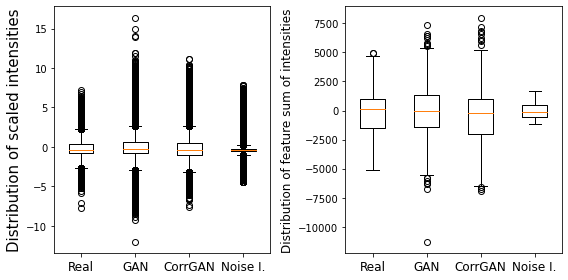

In [61]:
f, (axl, axr) = plt.subplots(1,2, figsize=(8,4))

names = ['Real', 'GAN', 'CorrGAN', 'Noise I.']
axl.boxplot([ds.values.flatten() for ds in data_repo])
axl.set_ylabel('Distribution of scaled intensities', fontsize=15)
axl.set_xticklabels(names, fontsize=12)
#axl.set_yticks([-2, 0, 2, 4])

axr.boxplot([ds.sum(axis=1) for ds in data_repo])
axr.set_ylabel('Distribution of feature sum of intensities', fontsize=12)
axr.set_xticklabels(names, fontsize=12)

plt.tight_layout()
plt.show()
f.savefig('images/GD_characteristics.png' , dpi=300)

### Hierarchical Clustering

Hierarchical clustering of the latest predictions and testing data (96 random samples from generated data). 

In [62]:
test_data = all_data[-3*batch_size:]

dfs_temp = np.concatenate((test_data, saved_predictions[-1].values))
test_labels = np.array(lbls)[np.random.RandomState(seed=145).permutation(len(data_NGP))][-3*batch_size:]
temp_lbls = list(test_labels) + ['gen_vinifera']*(len(saved_predictions[-1])//2) + ['gen_wild']*(len(saved_predictions[-1])//2)

hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='average')

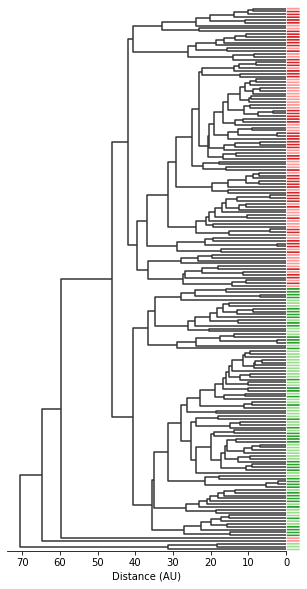

In [63]:
f, ax = plt.subplots(figsize=(5, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
#plt.legend(ordered_labels_test, colours2)
plt.show()

Hierarchical clustering of the latest predictions and experimental data.

In [64]:
dfs_temp = np.concatenate((datasets['vitis_types']['NGP'].values, saved_predictions[-1].values*(2*data_NGP.values.std())))
#test_labels = datasets['vitis_types']['NGP'].values
temp_lbls = list(datasets['vitis_types']['target']) + ['gen_vinifera']*(len(saved_predictions[-1])//2) + ['gen_wild']*(len(saved_predictions[-1])//2)
hca_results = gem.perform_HCA(dfs_temp, temp_lbls, metric='euclidean', method='ward')

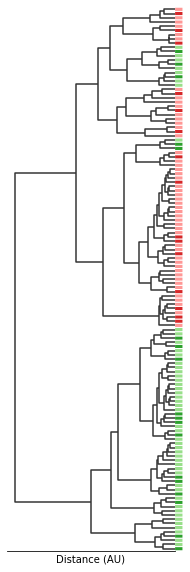

In [65]:
f, ax = plt.subplots(figsize=(3, 10))
gem.plot_dendogram(hca_results['Z'], 
               temp_lbls, ax=ax,
               label_colors=label_colors_test, title='',
               color_threshold=0)
ax.set_yticklabels([])
ax.set_xticks([])
plt.show()
f.savefig('images/GD_HCAPlot.png' , dpi=300)

### Coverage and Density

In [66]:
training_set = tf.constant(all_data)#[:-3*batch_size]

density_list, coverage_list = gem.evaluation_coverage_density_all_k_at_once(training_set, 
                                                                            saved_predictions[-1], 
                                                                            metric='Euclidean')

density_list_test, coverage_list_test = gem.evaluation_coverage_density_all_k_at_once(training_set, test_data, 
                                                                                      metric='Euclidean')

#testing_set = tf.constant(all_data[:-3*batch_size])
density_list_real, coverage_list_real = gem.evaluation_coverage_density_all_k_at_once(datasets['vitis_types']['NGP'], 
                                                                                saved_predictions[-1]*(2*data_NGP.values.std()),
                                                                                      metric='Euclidean')

density_list_corr, coverage_list_corr = gem.evaluation_coverage_density_all_k_at_once(training_set, 
                                                                                      corr_preds,
                                                                                      metric='Euclidean')

density_list_noise, coverage_list_noise = gem.evaluation_coverage_density_all_k_at_once(training_set, 
                                                                                      int_noise_df,
                                                                                      metric='Euclidean')

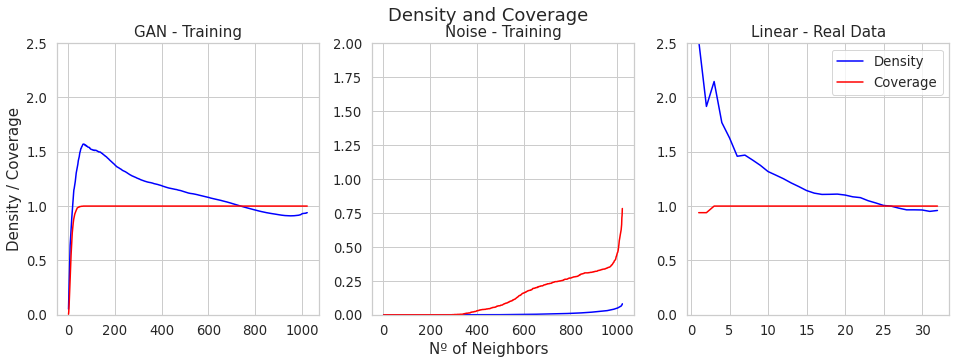

In [67]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,5))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(training_set)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(training_set)), coverage_list, label='Coverage', color='red')
        axl.set_title('GAN - Training', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,2.5])
        
        axc.plot(range(1,len(training_set)), density_list_noise, label='Density', color='blue')
        axc.plot(range(1,len(training_set)), coverage_list_noise, label='Coverage', color='red')
        axc.set_title('Noise - Training', fontsize=15)
        axc.set_ylim([0,2])
        
        #axc.plot(range(1,len(training_set)), density_list_test, label='Density', color='blue')
        #axc.plot(range(1,len(training_set)), coverage_list_test, label='Coverage', color='red')
        #axc.set_title('Test - Training', fontsize=15)
        #axc.set_ylim([0,2])
        
        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), density_list_real, label='Density', color='blue')
        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), coverage_list_real, label='Coverage', color='red')
        axr.set_title('Linear - Real Data', fontsize=15)
        axr.set_ylim([0,2.5])
        
        axr.legend()
        plt.suptitle('Density and Coverage', fontsize=18)

    f.text(0.5, 0.05, 'Nº of Neighbors', ha='center', va='top', fontsize=15)

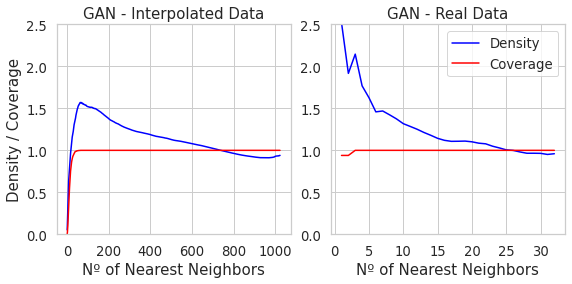

In [68]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (8,4))#, sharey='row')#, sharex='col')
        
        axl.plot(range(1,len(training_set)), density_list, label='Density', color='blue')
        axl.plot(range(1,len(training_set)), coverage_list, label='Coverage', color='red')
        axl.set_title('GAN - Interpolated Data', fontsize=15)
        axl.set_ylabel('Density / Coverage', fontsize=15)
        axl.set_ylim([0,2.5])
        axl.set_xlabel('Nº of Nearest Neighbors', fontsize=15)

        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), density_list_real, label='Density', color='blue')
        axr.plot(range(1,len(datasets['vitis_types']['NGP'])), coverage_list_real, label='Coverage', color='red')
        axr.set_title('GAN - Real Data', fontsize=15)
        axr.set_ylim([0,2.5])
        
        axr.legend()
        axr.set_xlabel('Nº of Nearest Neighbors', fontsize=15)
        #plt.suptitle('Density and Coverage', fontsize=18)

    plt.tight_layout()
    f.savefig('images/GD_DenCovPlot.png' , dpi=300)

### CrossLID (Local Intrinsic Dimensionality) Evaluation

In [69]:
training_set = tf.constant(all_data)#[:-3*batch_size]
CrossLIDs = {}

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP']/(
                                                    2*datasets['vitis_types']['NGP'].values.std()), predictions, 
                                                metric='euclidean')
CrossLIDs['RealVGAN'] = c_lid
print('Real - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(training_set, predictions, metric='euclidean')
CrossLIDs['LinearVGAN'] = c_lid
print('Linear - GAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP']/(
                                                    2*datasets['vitis_types']['NGP'].values.std()),
                                                    training_set, metric='euclidean')
CrossLIDs['RealVLinear'] = c_lid
print('Real - Linear Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP']/(
                                                    2*datasets['vitis_types']['NGP'].values.std()),
                                                    corr_preds, metric='euclidean')
CrossLIDs['RealVCorrGAN'] = c_lid
print('Real - CorrGAN Done')

c_lid = gem.cross_LID_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP'],
                                                    int_noise_df,
                                                    metric='euclidean')
CrossLIDs['RealVNoise'] = c_lid
print('Real - Noise Done')

Real - GAN Done
Linear - GAN Done
Real - Linear Done
Real - CorrGAN Done
Real - Noise Done


In [70]:
LIDs = {}

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(predictions, metric='euclidean')
LIDs['GAN'] = lid
print('GAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(data_NGP, metric='euclidean')
LIDs['Linear'] = lid
print('Linear Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(datasets['vitis_types']['NGP']/(
    2*datasets['vitis_types']['NGP'].values.std()), metric='euclidean')
LIDs['Real'] = lid
print('Real Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(corr_preds, metric='euclidean')
LIDs['CorrGAN'] = lid
print('CorrGAN Data Done')

lid = gem.local_intrinsic_dimensionality_estimator_byMLE_all_k_at_once(int_noise_df, metric='euclidean')
LIDs['Noise'] = lid
print('Noise Data Done')

GAN Data Done
Linear Data Done
Real Data Done
CorrGAN Data Done
Noise Data Done


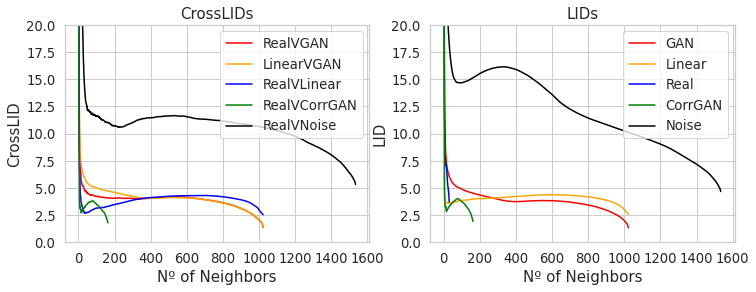

In [71]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(12,4))
        c = {'LinearVGAN': 'Orange', 'RealVGAN': 'Red', 'RealVLinear': 'Blue', 'RealVCorrGAN': 'Green', 'RealVNoise': 'black'}
        for l, data in CrossLIDs.items():
            axl.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axl.set_ylim([0,20])
        axl.legend()
        axl.set_xlabel('Nº of Neighbors', fontsize=15)
        axl.set_ylabel('CrossLID', fontsize=15)
        axl.set_title('CrossLIDs', fontsize=15)
        
        c = {'GAN': 'Red', 'Linear': 'Orange', 'Real': 'Blue', 'CorrGAN': 'Green', 'Noise': 'black'}
        for l, data in LIDs.items():
            axr.plot(range(2,len(data)+2), data, label=l, color = c[l])
            
        axr.set_ylim([0,20])
        axr.legend()
        axr.set_xlabel('Nº of Neighbors', fontsize=15)
        axr.set_ylabel('LID', fontsize=15)
        axr.set_title('LIDs', fontsize=15)

### Histograms
 
Histograms of Values of normal Real, Generated and GAN Generated Data.

In [72]:
# Predictions reverting the division by the standard deviation
last_preds = predictions*(2*data_NGP.values.std())

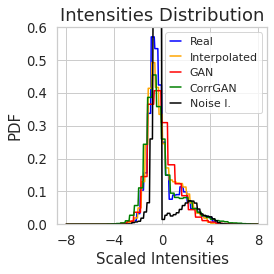

In [73]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-8, 8.01, 0.05)
        hist = np.histogram(datasets['vitis_types']['NGP'].values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        
        hist = np.histogram(data_NGP.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(last_preds.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram((corr_preds*(2*data_NGP.values.std())).values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram((int_noise_df).values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.set_ylabel('PDF', fontsize=15)
        ax.set_xlabel('Scaled Intensities', fontsize=15)
        ax.set_xticks([-8, -4, 0, 4, 8])
        ax.set_ylim([0,0.6])

        ax.legend(fontsize=11, handlelength=1)
        ax.set_title('Intensities Distribution', fontsize=18)
        plt.tight_layout()
        f.savefig('images/GD_IntPlot.png', dpi=300)

### Correlations between samples of Real Data and GAN Generated Data

In [74]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'], datasets['vitis_types']['NGP'],
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_lin_lin = gem.create_sample_correlations(data_NGP, data_NGP,
                                                   method='pearson')
print('Correlation Linear-Linear calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds, last_preds,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds, corr_preds,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df, int_noise_df,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

Correlation Real-Real calculation ended.
Correlation Linear-Linear calculation ended.
Correlation GAN-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation Noise-Noise calculation ended.


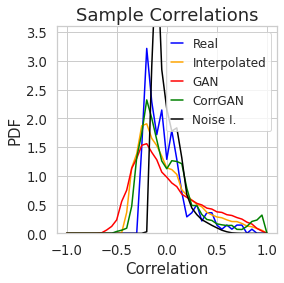

In [75]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_lin_lin.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten(), bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=12)
        ax.set_title('Sample Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)
        ax.set_ylim([0,3.6])

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/GD_SampCorrPlot.png', dpi=300)

### Correlations between features of Real, Generated and GAN Generated Samples

In [76]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'].T, datasets['vitis_types']['NGP'].T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gen_gen = gem.create_sample_correlations(data_NGP.T, data_NGP.T,
                                                   method='pearson')
print('Correlation Generated-Generated calculation ended.')

correlation_gan_gan = gem.create_sample_correlations(last_preds.T, last_preds.T,
                                                   method='pearson')
print('Correlation GAN-GAN calculation ended.')

correlation_corr_corr = gem.create_sample_correlations(corr_preds.T, corr_preds.T,
                                                   method='pearson')
print('Correlation CorrGAN-CorrGAN calculation ended.')

correlation_noise_noise = gem.create_sample_correlations(int_noise_df.T, int_noise_df.T,
                                                   method='pearson')
print('Correlation Noise-Noise calculation ended.')

Correlation Real-Real calculation ended.
Correlation Generated-Generated calculation ended.
Correlation GAN-GAN calculation ended.
Correlation CorrGAN-CorrGAN calculation ended.
Correlation Noise-Noise calculation ended.


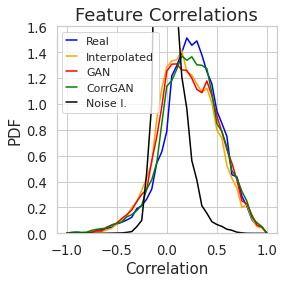

In [93]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (4,4))#, sharey='row')#, sharex='col')
        X = np.arange(-1, 1.01, 0.05)
        hist = np.histogram(correlation_real_real.values.flatten()[~np.isnan(correlation_real_real.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='blue', label='Real')
        ax.set_ylabel('PDF', fontsize=15)
        
        hist = np.histogram(correlation_gen_gen.values.flatten()[~np.isnan(correlation_gen_gen.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='orange', label='Interpolated')
        
        hist = np.histogram(correlation_gan_gan.values.flatten()[~np.isnan(correlation_gan_gan.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='red', label='GAN')
        
        hist = np.histogram(correlation_corr_corr.values.flatten()[~np.isnan(correlation_corr_corr.values.flatten())], bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='green', label='CorrGAN')
        
        hist = np.histogram(correlation_noise_noise.values.flatten()[~np.isnan(correlation_noise_noise.values.flatten())],
                            bins=50)
        hist_dist = stats.rv_histogram(hist)
        ax.plot(X, hist_dist.pdf(X), color='black', label='Noise I.')
        
        ax.legend(handlelength=1, fontsize=11, loc='upper left')
        ax.set_title('Feature Correlations', fontsize=18)
        ax.set_xlabel('Correlation', fontsize=15)
        ax.set_ylim([0,1.6])

    #f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)
    plt.tight_layout()
    f.savefig('images/GD_FeatCorrPlot.png', dpi=300)

### Sample Correlation Matrix

Between samples of the real data and a set of generated artificial samples of GANs

In [78]:
# Real Data, organize it to have first all samples of a class, then all samples of the other class
df = datasets['vitis_types']['NGP'].copy()

samp = df.index
tg = datasets['vitis_types']['target'].copy()
new_order = [x for _, x in sorted(zip(tg, samp))]
new_tg = [x for x, _ in sorted(zip(tg, samp))]

df = df.loc[new_order]
#df

In [79]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=last_preds.index, columns=df.index).astype('float')

for i in df.index:
    for j in last_preds.index:
        correlations.loc[j,i] = stats.spearmanr(df.loc[i],
                                               last_preds.loc[j])[0]

correlations.columns = new_tg
correlations.index = ['gen_vinifera']*(len(last_preds)//2) + ['gen_wild']*(len(last_preds)//2)

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


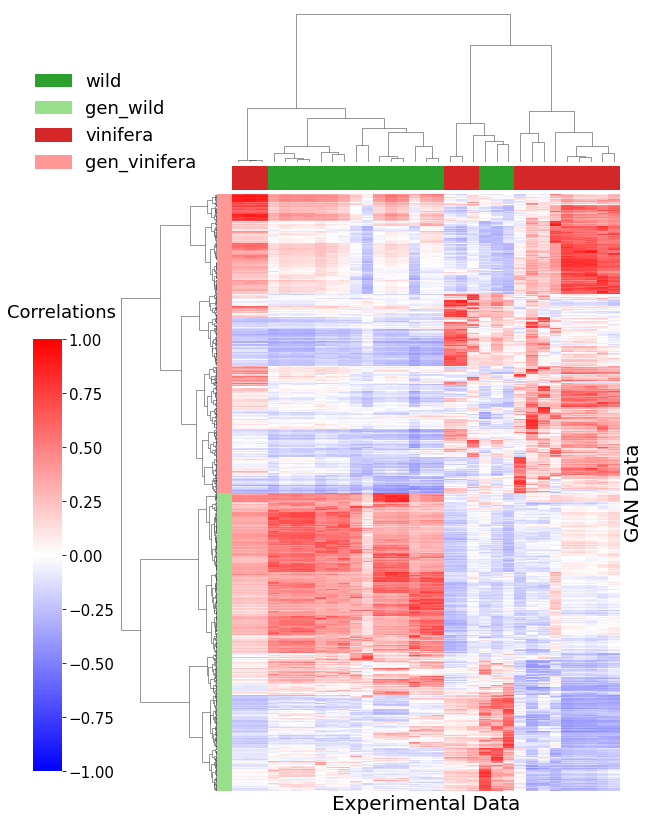

In [80]:
# Draw the clustermap
import matplotlib.patches as mpatches

row_cols = [label_colors_test[lbl] for lbl in new_tg]
row_cols2 = [label_colors_test[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2, vmin=-1, vmax=1, method='ward',
                  cbar_pos = (-0.13, 0.1, 0.05, 0.5))
g.fig.set_size_inches((8,12))
# some tweaks
patches = []
for lbl in ordered_labels_test:
    patches.append(mpatches.Patch(color=label_colors_test[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.5, 1.35, 0.5, 1),
                     frameon=False, fontsize=18) 
g.ax_heatmap.set_ylabel('GAN Data', fontsize=20)
g.ax_heatmap.set_xlabel('Experimental Data', fontsize=20)
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, labelright=False)

# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=15) 
plt.text(1, 1.10, 'Correlations', fontsize=18, horizontalalignment='center')
#g.savefig('clustermap_Tryp.png' , dpi=300)
plt.show()
g.savefig('images/GD_Clustermap.png', dpi=300)

In [81]:
# Calculate all correlations between all samples of real and artificial data and store them in a dataframe
correlations = pd.DataFrame(index=int_noise_df.index, columns=df.index).astype('float')

for i in df.index:
    for j in int_noise_df.index:
        correlations.loc[j,i] = stats.spearmanr(df.loc[i],
                                               int_noise_df.loc[j])[0]

correlations.columns = new_tg
correlations.index = ['gen_vinifera']*(len(int_noise_df)//2) + ['gen_wild']*(len(int_noise_df)//2)

C:\Users\franc\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


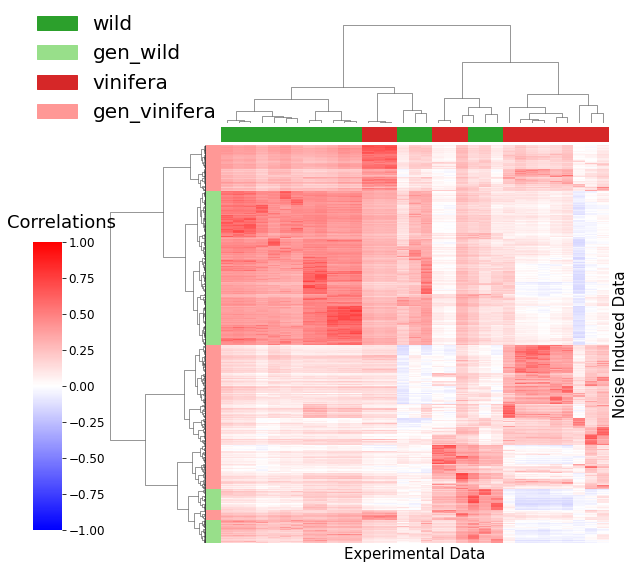

In [82]:
# Draw the clustermap
import matplotlib.patches as mpatches

row_cols = [label_colors_test[lbl] for lbl in new_tg]
row_cols2 = [label_colors_test[lbl] for lbl in correlations.index]
g = sns.clustermap(correlations, col_colors=row_cols, cmap='bwr', row_colors= row_cols2, vmin=-1, vmax=1, method='ward',
                  cbar_pos = (-0.11, 0.1, 0.05, 0.5))
g.fig.set_size_inches((8,8))
# some tweaks
patches = []
for lbl in ordered_labels_test:
    patches.append(mpatches.Patch(color=label_colors_test[lbl], label=lbl))
leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.5, 1.35, 0.5, 1),
                     frameon=False, fontsize=20) 
g.ax_heatmap.set_ylabel('Noise Induced Data', fontsize=15)
g.ax_heatmap.set_xlabel('Experimental Data', fontsize=15)
g.ax_heatmap.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, labelright=False)

# Manually specify colorbar labelling after it's been generated
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12) 
plt.text(1, 1.10, 'Correlations', fontsize=18, horizontalalignment='center')
#g.savefig('clustermap_Tryp.png' , dpi=300)
plt.show()
#g.savefig('images/GD_Clustermap.png', dpi=300)

### CAS (Classification Accuracy Score)

See how well a model of Generated Samples can classify both linearly generated data (used to train the model) and real experimental data.

In [83]:
# GAN Data labels in written and 1/0 form
last_preds = predictions*(2*data_NGP.values.std())
last_preds_labels = [1]*(len(last_preds)//2) + [0]*(len(last_preds)//2)
last_preds_labels2 = ['vinifera']*(len(last_preds)//2) + ['wild']*(len(last_preds)//2)

# Correlated GAN Data labels in written form        
corr_lbls2 = []
for i in corr_lbls:
    if i == 1:
        corr_lbls2.append('vinifera')
    else:
        corr_lbls2.append('wild')

# Test Data and corresponding labels - linearly generated data
t_data = data_NGP
t_labels = lbls


# Real data and its labels
r_data = datasets['vitis_types']['NGP']
r_labels = datasets['vitis_types']['target']

**Random Forest Tests**

In [84]:
# Optimizing the model
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
top_tree_in_grid=300

# Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=100)
clf = GridSearchCV(rf, values, cv=5)

# GAN Data
clf.fit(last_preds, last_preds_labels2)
GAN_param = clf.cv_results_['param_n_estimators']
GAN_test_score = clf.cv_results_['mean_test_score']

#CorrGAN data
clf.fit(corr_preds, corr_lbls2)
corr_param = clf.cv_results_['param_n_estimators']
corr_test_score = clf.cv_results_['mean_test_score']

#Noise data
clf.fit(int_noise_df, int_noise_lbls)
noise_param = clf.cv_results_['param_n_estimators']
noise_test_score = clf.cv_results_['mean_test_score']

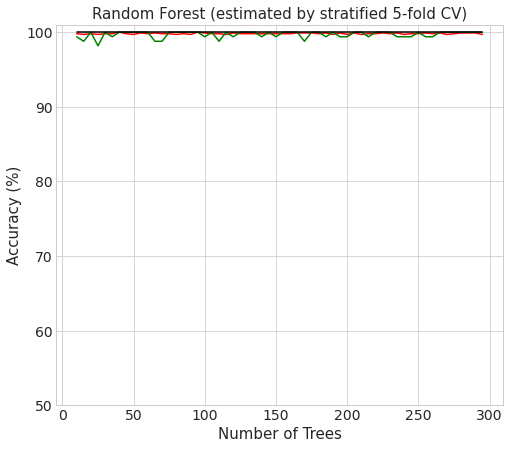

In [85]:
# Plotting the results and adjusting parameters of the plot
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(figsize=(8,7))

    plt.plot(GAN_param, GAN_test_score*100, color='red', label='GAN Data')
    plt.plot(corr_param, corr_test_score*100, color='green', label='CorrGAN Data')
    plt.plot(noise_param, noise_test_score*100, color='black', label='Noise Data')

    plt.ylabel('Accuracy (%)', fontsize = 15)
    plt.xlabel('Number of Trees', fontsize = 15)
    plt.ylim(50,101)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Random Forest (estimated by stratified 5-fold CV)', fontsize=15)

In [86]:
# Fitting the model Generated samples
rf_mod = ma.RF_model(last_preds, last_preds_labels2, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 99.51171875 %.
Predicting Experimental Data 90.9090909090909 %.


In [87]:
# Fitting the model Correlated Generated samples
rf_mod = ma.RF_model(corr_preds*(2*data_NGP.values.std()), 
                     corr_lbls2, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from CorrGAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from CorrGAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 93.93939393939394 %.


In [88]:
# Fitting the model Induced Noise and Imputation samples
rf_mod = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=True, iter_num=1, n_trees=200, cv=None, n_fold=5)

# Testing the linearly generated test data
print('Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', rf_mod['model'].score(t_data, t_labels)*100, '%.')

# Testing the real data
print('Predicting Experimental Data', rf_mod['model'].score(r_data, r_labels)*100, '%.')

Classifier from Noise Induced and Intensity Imputed Data Performance in predicting other samples:
Predicting Linearly Generated Data 99.90234375 %.
Predicting Experimental Data 100.0 %.


C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


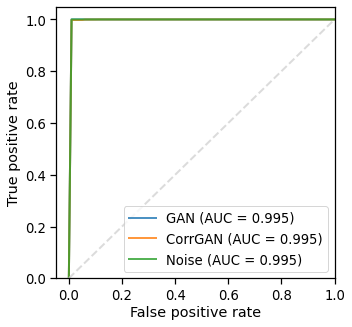

In [89]:
res_roc = {}
res_roc['GAN'] = ma.RF_ROC_cv(predictions, last_preds_labels2, 'vinifera', n_fold=5, n_trees=200, n_iter=50)
res_roc['CorrGAN'] = ma.RF_ROC_cv(corr_preds*(2*data_NGP.values.std()),
                                  corr_lbls2, 'vinifera', n_fold=5, n_trees=200, n_iter=50)
res_roc['Noise'] = ma.RF_ROC_cv(int_noise_df, int_noise_lbls, 'vinifera', n_fold=5, n_trees=200, n_iter=50)

with sns.plotting_context("notebook", font_scale=1.2):
    f, ax = plt.subplots(1, 1, figsize=(5,5))
    for name, res in res_roc.items():
        mean_fpr = res['average fpr']
        mean_tpr = res['average tpr']
        mean_auc = res['mean AUC']
        ax.plot(mean_fpr, mean_tpr,
               label=f'{name} (AUC = {mean_auc:.3f})',
               lw=2, alpha=0.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
    ax.legend()
    ax.set_xlim(None,1)
    ax.set_ylim(0,None)
    ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
          # title="Random forest ROC curves for Vitis types data set")
    plt.show()

PLS-DA Tests

In [90]:
def decision_rule(y_pred, y_true):
    "Decision rule for PLS-DA classification."
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction


    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

In [94]:
# Optimizing the model
GAN_optim_pls = ma.optim_PLSDA_n_components(last_preds, last_preds_labels2, 
                                            encode2as1vector=True, max_comp=10, n_fold=5).CVscores
corr_optim_pls = ma.optim_PLSDA_n_components(corr_preds, corr_lbls2, encode2as1vector=True, max_comp=10, n_fold=5).CVscores
noise_optim_pls = ma.optim_PLSDA_n_components(int_noise_df, int_noise_lbls,
                                              encode2as1vector=True, max_comp=10, n_fold=5).CVscores

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 144
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 143
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 143
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 144
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 143
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\franc\

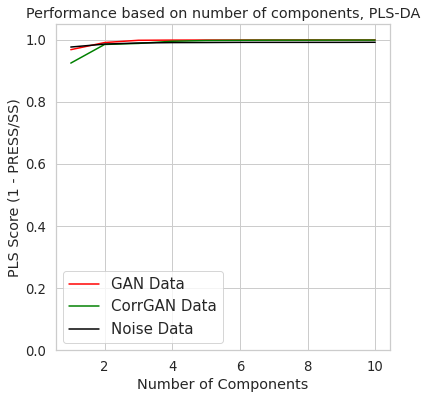

In [95]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        
        ax.plot(range(1, len(GAN_optim_pls) + 1), GAN_optim_pls, color='red', label='GAN Data')
        ax.plot(range(1, len(corr_optim_pls) + 1), corr_optim_pls, color='green', label='CorrGAN Data')
        ax.plot(range(1, len(noise_optim_pls) + 1), noise_optim_pls, color='black', label='Noise Data')
        ax.set(xlabel='Number of Components',
                ylabel='PLS Score (1 - PRESS/SS)',
                title='Performance based on number of components, PLS-DA')
        ax.set_ylim([0, 1.05])
        ax.legend(fontsize=15)

Fitting the model - GAN Data

In [96]:
# Cross Validation Score
cv_plsda_model = ma.PLSDA_model_CV(last_preds, last_preds_labels2, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

np.mean(cv_plsda_model['accuracy'])

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

1.0

In [97]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(last_preds, last_preds_labels2,
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(last_preds_labels2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(last_preds_labels2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - CorrGAN Data

In [98]:
# Cross Validation Score
cv_plsda_model = ma.PLSDA_model_CV(corr_preds*(2*data_NGP.values.std()), corr_lbls2, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

np.mean(cv_plsda_model['accuracy'])

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

1.0

In [99]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(corr_preds*(2*data_NGP.values.std()), corr_lbls2,
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(corr_lbls2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(corr_lbls2), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - Noise Data

In [100]:
# Cross Validation Score
cv_plsda_model = ma.PLSDA_model_CV(int_noise_df, int_noise_lbls, n_comp=4,
                   n_fold=5, iter_num=20,
                   encode2as1vector=True, feat_type='Coef')

np.mean(cv_plsda_model['accuracy'])

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

1.0

In [101]:
# Classifier Accuracy 
plsda = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls,
                           n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True)

# Obtain results with the linearly generated data
y_pred = plsda.predict(t_data)

test_labels = ma._generate_y_PLSDA(t_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Classifier from GAN Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy*100, '%.')

# Obtain results with the linearly generated data
y_pred = plsda.predict(r_data)

test_labels = ma._generate_y_PLSDA(r_labels, pd.unique(int_noise_lbls), True)

# Calculate accuracy based on the decision rule
accuracy = decision_rule(y_pred, test_labels)
print('Predicting Experimental Data', accuracy*100, '%.')

Classifier from GAN Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


PLS-DA projections

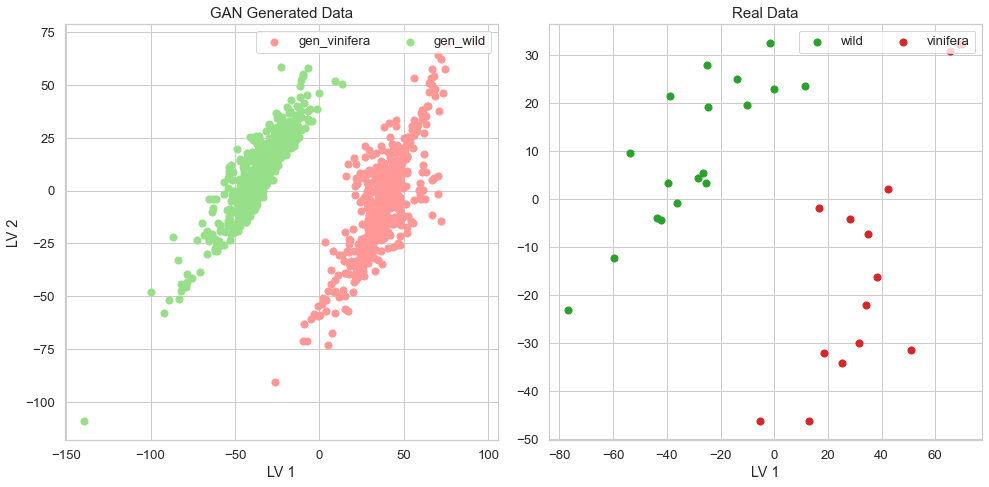

In [102]:
n_components = 4

last_preds_labels_2 = ['gen_vinifera']*(len(last_preds)//2) + ['gen_wild']*(len(last_preds)//2)
#t_labels_2 = ['vinifera' for i in true_labels[-3*batch_size:] if i==0 else 'wild']


model, scores = ma.fit_PLSDA_model(last_preds, last_preds_labels_2, n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(r_data, r_labels, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="GAN Generated Data", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        gem.plot_PLS(scores2, lcolors, title="Real Data", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)       
        axl.legend(loc='upper right', ncol=2)       
        plt.tight_layout()
        plt.show()

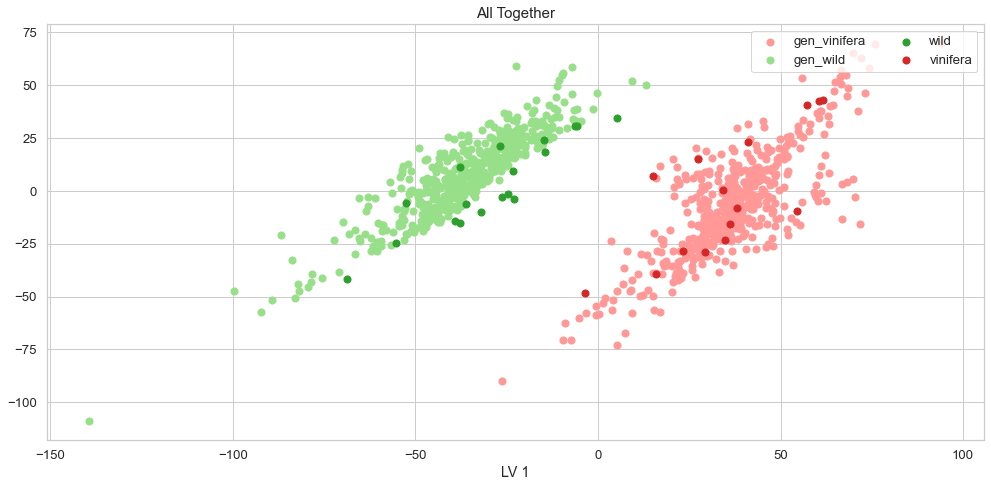

In [103]:
n_components = 4

df_temp = pd.concat([last_preds, r_data])
labels_temp = last_preds_labels_2 + r_labels

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

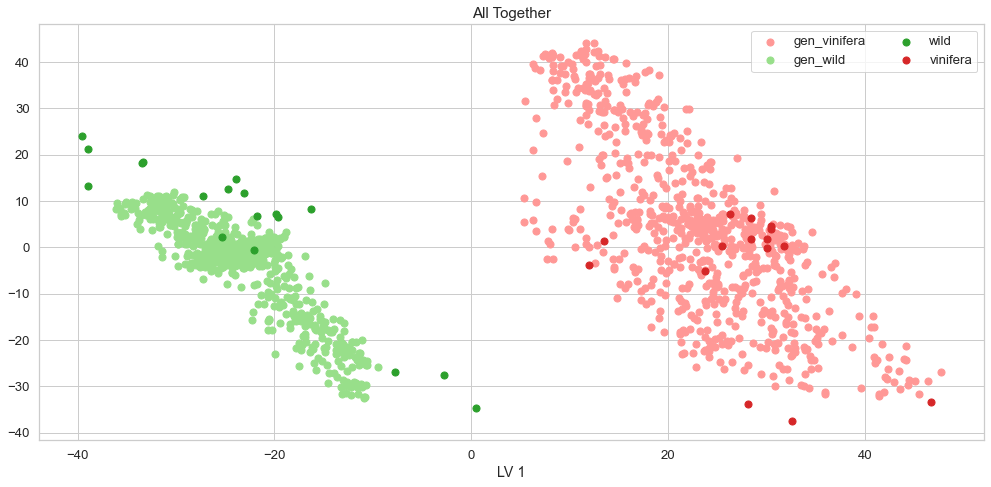

In [104]:
n_components = 4

int_noise_df.columns = [float(i) for i in int_noise_df.columns]
df_temp = pd.concat([int_noise_df, r_data])
labels_temp = ['gen_' + i for i in int_noise_lbls] + r_labels

model, scores = ma.fit_PLSDA_model(df_temp, labels_temp, n_comp=n_components)

#ordered_labels_test = ('wild','gen_wild','vinifera','gen_vinifera')
lcolors = label_colors_test

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        gem.plot_PLS(scores, lcolors, title="All Together", ax=ax)

        ax.set_ylabel('')
        ax.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

Deep Learning methodology

In [105]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

Fitting the model - GAN Data

In [106]:
deep_class = deep_classifier(len(last_preds.columns))
model = deep_class.fit(last_preds, pd.get_dummies(last_preds_labels2)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
32/32 [==============================] - 4s 85ms/step - loss: 0.0245 - accuracy: 0.9902 - val_loss: 2.0761e-05 - val_accuracy: 1.0000
Epoch 2/100
32/32 [==============================] - 3s 89ms/step - loss: 0.0017 - accuracy: 0.9990 - val_loss: 7.7259e-05 - val_accuracy: 1.0000
Epoch 3/100
32/32 [==============================] - 2s 71ms/step - loss: 4.3741e-04 - accuracy: 1.0000 - val_loss: 5.8370e-05 - val_accuracy: 1.0000
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 6.9558e-05 - accuracy: 1.0000 - val_loss: 4.5323e-05 - val_accuracy: 1.0000
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 7.9795e-05 - accuracy: 1.0000 - val_loss: 4.1563e-05 - val_accuracy: 1.0000
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 2.0105e-04 - accuracy: 1.0000 - val_loss: 2.5707e-05 - val_accuracy: 1.0000
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 1.2655e-04 - accuracy: 1.0000 - val_

Epoch 56/100
32/32 [==============================] - 0s 7ms/step - loss: 1.7600e-05 - accuracy: 1.0000 - val_loss: 4.9670e-06 - val_accuracy: 1.0000
Epoch 57/100
32/32 [==============================] - 0s 8ms/step - loss: 9.7102e-06 - accuracy: 1.0000 - val_loss: 4.8911e-06 - val_accuracy: 1.0000
Epoch 58/100
32/32 [==============================] - 0s 7ms/step - loss: 1.0196e-06 - accuracy: 1.0000 - val_loss: 5.1440e-06 - val_accuracy: 1.0000
Epoch 59/100
32/32 [==============================] - 0s 8ms/step - loss: 6.5014e-06 - accuracy: 1.0000 - val_loss: 4.9272e-06 - val_accuracy: 1.0000
Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 1.5380e-05 - accuracy: 1.0000 - val_loss: 4.5407e-06 - val_accuracy: 1.0000
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 1.5612e-05 - accuracy: 1.0000 - val_loss: 4.3926e-06 - val_accuracy: 1.0000
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 2.4874e-06 - accuracy: 1.0

In [107]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - CorrGAN Data

In [108]:
deep_class = deep_classifier(len(corr_preds.columns))
model = deep_class.fit(corr_preds, pd.get_dummies(corr_lbls2)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
6/6 [==============================] - 1s 53ms/step - loss: 0.2711 - accuracy: 0.8537 - val_loss: 1.7267e-06 - val_accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0837e-07 - val_accuracy: 1.0000
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0502 - accuracy: 0.9878 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0259 - accuracy: 0.9878 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.3618e-06 - val_accuracy: 1.0

Epoch 58/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 6.7440e-05 - val_accuracy: 1.0000
Epoch 59/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 60/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 6.0693e-04 - val_accuracy: 1.0000
Epoch 61/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.1750e-04 - val_accuracy: 1.0000
Epoch 62/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3873e-05 - val_accuracy: 1.0000
Epoch 63/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.1527e-05 - val_accuracy: 1.0000
Epoch 64/100
6/6 [==============================] - 0s 16ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 7.9795e-06 - val_accura

In [109]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


Fitting the model - Noise Data

In [110]:
deep_class = deep_classifier(len(int_noise_df.columns))
model = deep_class.fit(int_noise_df, pd.get_dummies(int_noise_lbls)[['vinifera', 'wild']], 
                       epochs = 100, batch_size=32,
                       validation_data=(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']]))

accuracy_t = deep_class.evaluate(t_data, pd.get_dummies(t_labels)[['vinifera', 'wild']])
accuracy_r = deep_class.evaluate(r_data, pd.get_dummies(r_labels)[['vinifera', 'wild']])

Epoch 1/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0168 - accuracy: 0.9935 - val_loss: 1.0880e-05 - val_accuracy: 1.0000
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 6.2978e-04 - accuracy: 1.0000 - val_loss: 3.4052e-04 - val_accuracy: 1.0000
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 1.6234e-04 - accuracy: 1.0000 - val_loss: 4.1505e-05 - val_accuracy: 1.0000
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 6.7959e-05 - accuracy: 1.0000 - val_loss: 1.3322e-05 - val_accuracy: 1.0000
Epoch 5/100
48/48 [==============================] - 0s 8ms/step - loss: 2.2742e-05 - accuracy: 1.0000 - val_loss: 2.1773e-05 - val_accuracy: 1.0000
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 3.7763e-05 - accuracy: 1.0000 - val_loss: 2.4919e-05 - val_accuracy: 1.0000
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 1.8645e-05 - accuracy: 1.0000 - val_

48/48 [==============================] - 0s 9ms/step - loss: 3.7773e-07 - accuracy: 1.0000 - val_loss: 4.6743e-06 - val_accuracy: 1.0000
Epoch 56/100
48/48 [==============================] - 0s 10ms/step - loss: 3.5437e-06 - accuracy: 1.0000 - val_loss: 5.2016e-06 - val_accuracy: 1.0000
Epoch 57/100
48/48 [==============================] - 0s 9ms/step - loss: 8.6960e-07 - accuracy: 1.0000 - val_loss: 5.1546e-06 - val_accuracy: 1.0000
Epoch 58/100
48/48 [==============================] - 0s 8ms/step - loss: 2.7693e-06 - accuracy: 1.0000 - val_loss: 4.3636e-06 - val_accuracy: 1.0000
Epoch 59/100
48/48 [==============================] - 0s 9ms/step - loss: 4.1440e-06 - accuracy: 1.0000 - val_loss: 2.4167e-06 - val_accuracy: 1.0000
Epoch 60/100
48/48 [==============================] - 0s 9ms/step - loss: 4.3734e-06 - accuracy: 1.0000 - val_loss: 2.2505e-06 - val_accuracy: 1.0000
Epoch 61/100
48/48 [==============================] - 0s 9ms/step - loss: 3.0082e-07 - accuracy: 1.0000 - val_lo

In [111]:
print('Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:')
print('Predicting Linearly Generated Data', accuracy_t[1]*100, '%.')
print('Predicting Experimental Data', accuracy_r[1]*100, '%.')

Classifier from Noise Induced and Imputed Generated Data Performance in predicting other samples:
Predicting Linearly Generated Data 100.0 %.
Predicting Experimental Data 100.0 %.


### Comparing Important Features

See models built with a lot of GAN generated data and the real data and compare the important features selected by both (values and identities).

In [112]:
# Generate GAN samples
num_examples_to_generate = 2048
test_input = tf.constant(input_realdata_dist.rvs(size=data_NGP.shape[1]*num_examples_to_generate), 
                         shape=[num_examples_to_generate,data_NGP.shape[1]])
test_labels = tf.constant([1]*(num_examples_to_generate//2) + [0]*(num_examples_to_generate//2), shape=[
        num_examples_to_generate,1])
predictions = generator([test_input, test_labels], training=False)
predictions = pd.DataFrame(predictions.numpy(), columns=datasets['vitis_types']['NGP'].columns)

#### RF

Feature Importance judged by Gini Importance

In [113]:
# Fit RF models
np.random.seed(137532)
RF_model_GANdata = ma.RF_model(predictions, test_labels.numpy().flatten(), return_cv=False, n_trees=200)
RF_model_REALdata = ma.RF_model(datasets['vitis_types']['NGP'], datasets['vitis_types']['target'], return_cv=False, n_trees=200)
RF_model_CORRdata = ma.RF_model(corr_preds, corr_lbls2, return_cv=False, n_trees=200)
RF_model_NOISEdata = ma.RF_model(int_noise_df, int_noise_lbls, return_cv=False, n_trees=200)

In [114]:
# Extract and order important features
rf_GAN_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), RF_model_GANdata.feature_importances_)
rf_real_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), RF_model_REALdata.feature_importances_)
rf_corr_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), RF_model_CORRdata.feature_importances_)
rf_noise_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), RF_model_NOISEdata.feature_importances_)

rf_GAN_df = pd.DataFrame(rf_GAN_feats)
rf_real_df = pd.DataFrame(rf_real_feats)
rf_corr_df = pd.DataFrame(rf_corr_feats)
rf_noise_df = pd.DataFrame(rf_noise_feats)

In [115]:
# Sorting from most to least important feature
sorted_GAN_feats = rf_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_GAN_feats

,1
0,
1061,0.032180
1621,0.021498
3240,0.021227
1176,0.018907
1229,0.018671
...,...
1345,0.000000
1346,0.000000
1347,0.000000


In [116]:
# Sorting from most to least important feature
sorted_real_feats = rf_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = rf_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = rf_noise_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats

,1
0,
2136,0.016920
892,0.015000
1940,0.014768
671,0.014340
3617,0.013804
...,...
1291,0.000000
1292,0.000000
1293,0.000000


In [117]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with CorrGAN or Experimental Data
intersections_corr= []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))
    
# See intersections between important features of models generated with Noise Induced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i])))   

# See intersections if features were randomly shuffled
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

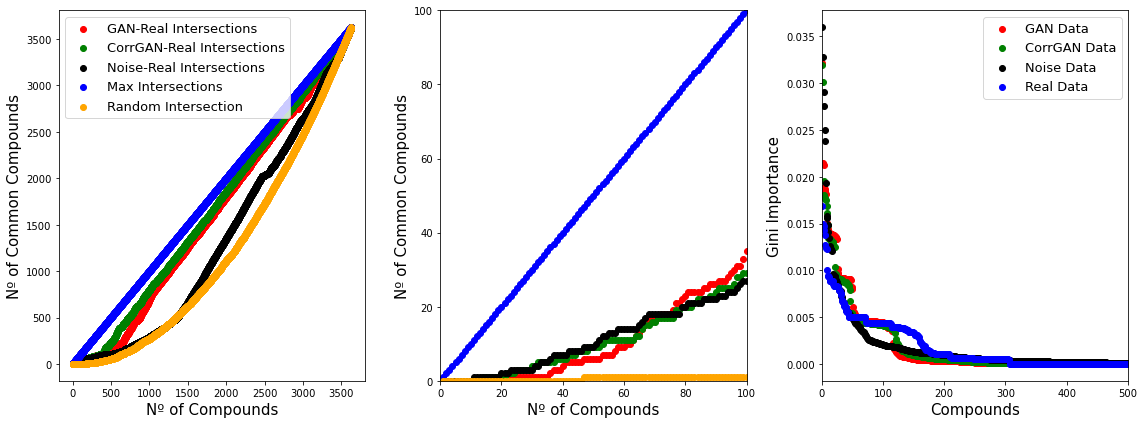

In [118]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')

axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.tight_layout()
plt.show()
#f.savefig('images/GD_RFImpFeatPlot.png', dpi=300)

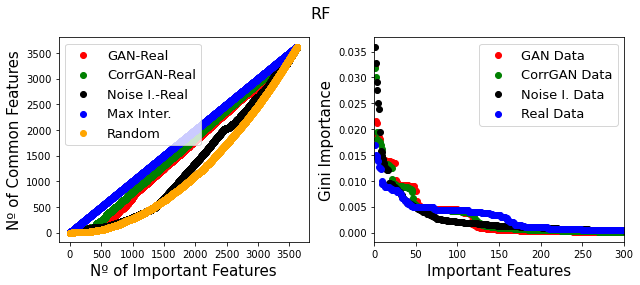

In [119]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Important Features', fontsize=15)
axl.set_ylabel('Nº of Common Features', fontsize=15)

# Values of Gini Importance for RF models from GAN and Real Data
axr.scatter(range(1,len(rf_GAN_df)+1), rf_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(rf_corr_df)+1), rf_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(rf_noise_df)+1), rf_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(rf_real_df)+1), rf_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,300])
axr.legend(fontsize=13)
axr.set_xlabel('Important Features', fontsize=15)
axr.set_ylabel('Gini Importance', fontsize=15)

plt.suptitle('RF', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/GD_RFImpFeatPlot.png', dpi=300)

#### PLS-DA

Feature Importance judged by VIP (Variable Importance in Projection)

In [120]:
# Fit the PLS-DA model
np.random.seed(137532)
PLSDA_model_GANdata = ma.fit_PLSDA_model(predictions, test_labels.numpy().flatten(), n_comp=4, return_scores=False,
                    scale=False, encode2as1vector=True) 
PLSDA_model_REALdata = ma.fit_PLSDA_model(datasets['vitis_types']['NGP'], datasets['vitis_types']['target'], 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_CORRdata = ma.fit_PLSDA_model(corr_preds, corr_lbls2, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)
PLSDA_model_NOISEdata = ma.fit_PLSDA_model(int_noise_df, int_noise_lbls, 
                                          n_comp=4, return_scores=False, scale=False, encode2as1vector=True)

In [121]:
# Extract and order important features
plsda_GAN_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), ma._calculate_vips(PLSDA_model_GANdata))
plsda_real_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), ma._calculate_vips(PLSDA_model_REALdata))
plsda_corr_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), ma._calculate_vips(PLSDA_model_CORRdata))
plsda_noise_feats = zip(range(1, len(datasets['vitis_types']['NGP'].columns)+1), ma._calculate_vips(PLSDA_model_NOISEdata))

plsda_GAN_df = pd.DataFrame(plsda_GAN_feats)
plsda_real_df = pd.DataFrame(plsda_real_feats)
plsda_corr_df = pd.DataFrame(plsda_corr_feats)
plsda_noise_df = pd.DataFrame(plsda_noise_feats)

In [122]:
# Sorting from most to least important feature
sorted_GAN_feats = plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False)
sorted_real_feats = plsda_real_df.set_index(0).sort_values(by=1, ascending=False)
sorted_corr_feats = plsda_corr_df.set_index(0).sort_values(by=1, ascending=False)
sorted_noise_feats = plsda_noise_df.set_index(0).sort_values(by=1, ascending=False)

In [123]:
# See intersections between important features of models generated with GAN or Experimental Data
intersections = []
for i in range(1, len(sorted_GAN_feats)):
    intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], sorted_real_feats.index[:i])))

# See intersections between important features of models generated with CorrGAN or Experimental Data
intersections_corr= []
for i in range(1, len(sorted_corr_feats)):
    intersections_corr.append(len(np.intersect1d(sorted_corr_feats.index[:i], sorted_real_feats.index[:i])))
    
# See intersections between important features of models generated with NoiseInduced or Experimental Data
intersections_noise= []
for i in range(1, len(sorted_noise_feats)):
    intersections_noise.append(len(np.intersect1d(sorted_noise_feats.index[:i], sorted_real_feats.index[:i])))   

# See intersections if features were randomly shuffled
random_intersections = []
copy_shuffle = list(sorted_real_feats.index).copy()
np.random.shuffle(copy_shuffle)
for i in range(1, len(sorted_GAN_feats)):
    random_intersections.append(len(np.intersect1d(sorted_GAN_feats.index[:i], copy_shuffle[:i])))

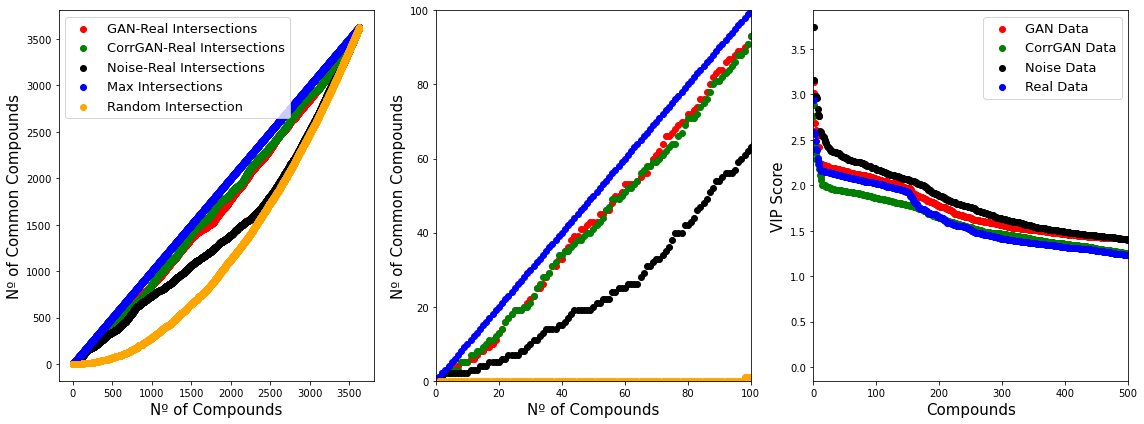

In [124]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Compounds', fontsize=15)
axl.set_ylabel('Nº of Common Compounds', fontsize=15)

# Graph depicting intersection of important features with focus on the most important features
axc.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real Intersections', color='Red')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real Intersections', color='Green')
axc.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise-Real Intersections', color='Black')
axc.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Intersections', color='Blue')
axc.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random Intersection', color='Orange')
axc.set_xlim([0,100])
axc.set_ylim([0,100])
axc.set_xlabel('Nº of Compounds', fontsize=15)
axc.set_ylabel('Nº of Common Compounds', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Compounds', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.tight_layout()
plt.show()

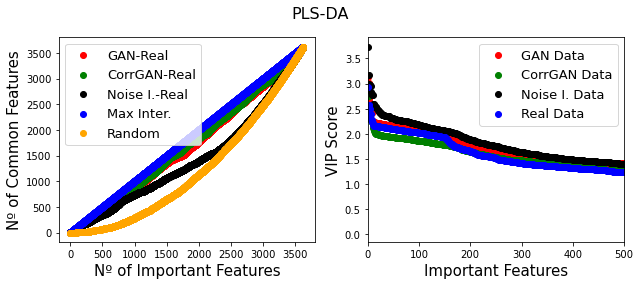

In [125]:
f, (axl, axr) = plt.subplots(1,2,figsize=(9,4))
# Graph depicting intersection of important features
axl.scatter(range(1,len(sorted_GAN_feats)), intersections, label = 'GAN-Real', color='Red')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_corr, label = 'CorrGAN-Real', color='Green')
axl.scatter(range(1,len(sorted_GAN_feats)), intersections_noise, label = 'Noise I.-Real', color='Black')
axl.scatter(range(1,len(sorted_GAN_feats)), range(1,len(sorted_GAN_feats)), label = 'Max Inter.', color='Blue')
axl.scatter(range(1,len(sorted_GAN_feats)), random_intersections, label = 'Random', color='Orange')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Nº of Important Features', fontsize=15)
axl.set_ylabel('Nº of Common Features', fontsize=15)

# Values of VIP Score for PLS-DA models from GAN and Real Data
axr.scatter(range(1,len(plsda_GAN_df)+1), plsda_GAN_df.set_index(0).sort_values(by=1, ascending=False), 
            color='red', label='GAN Data')
axr.scatter(range(1,len(plsda_corr_df)+1), plsda_corr_df.set_index(0).sort_values(by=1, ascending=False), 
            color='green', label='CorrGAN Data')
axr.scatter(range(1,len(plsda_noise_df)+1), plsda_noise_df.set_index(0).sort_values(by=1, ascending=False), 
            color='black', label='Noise I. Data')
axr.scatter(range(1,len(plsda_real_df)+1), plsda_real_df.set_index(0).sort_values(by=1, ascending=False), 
            color='blue', label='Real Data')
axr.set_xlim([0,500])
axr.legend(fontsize=13)
axr.set_xlabel('Important Features', fontsize=15)
axr.set_ylabel('VIP Score', fontsize=15)

plt.suptitle('PLS-DA', fontsize=16)
plt.tight_layout()
plt.show()
f.savefig('images/GD_PLSDAImpFeatPlot.png', dpi=300)

### Cross Validation and variation on CAS

Variation on CAS Score, here we divided our dataset, getting 11 folds where each has 30 samples that act as the 'training set' and the remaining 3 samples as the 'test set'.

With the train set, we build and train a GAN model from them. Then we build models with the train set and with generated artificial samples from the GAN models and compare the performance in discriminating the test set.

Note: They are put already treated since applying pre-treatment to only 3 samples can affect the results a lot.

In [126]:
from sklearn.model_selection import train_test_split, StratifiedKFold
kf = StratifiedKFold(11, shuffle=True, random_state=7519)

# Make the folds
folds_test = {}
folds_train = {}
a = 1

for train_index, test_index in kf.split(datasets['vitis_types']['NGP'], datasets['vitis_types']['target']):
    #print(datasets['vitis_types']['BinSim'].iloc[train_index].copy())
    train_data = datasets['vitis_types']['NGP'].iloc[train_index].copy()
    #grapevine_classes = train_data.index.get_level_values(0)
    train_lbls = list(np.array(datasets['vitis_types']['target'])[train_index])
    
    test_data = datasets['vitis_types']['NGP'].iloc[test_index].copy()
    test_lbls = np.array(datasets['vitis_types']['target'])[test_index]
    
    folds_test[a] = [test_data, test_lbls]
    folds_train[a] = [train_data, train_lbls]
    
    a+=1

In [127]:
# Generate linearly generated samples of each fold
arti_train = {}
for i in folds_train:
    start = perf_counter()
    data, lbls = laf.artificial_dataset_generator(folds_train[i][0], labels=folds_train[i][1],
                                            max_new_samples_per_label=256, binary=False, rnd=list(np.linspace(0.1,0.9,9)), 
                                            binary_rnd_state=None, rnd_state=325)
    arti_train[i] = [data, lbls]
    end = perf_counter()
    print(f'Simple augmentation of train data fold {i} done! took {(end - start):.3f} s')    

Simple augmentation of train data fold 1 done! took 29.161 s
Simple augmentation of train data fold 2 done! took 30.891 s
Simple augmentation of train data fold 3 done! took 28.871 s
Simple augmentation of train data fold 4 done! took 29.157 s
Simple augmentation of train data fold 5 done! took 28.844 s
Simple augmentation of train data fold 6 done! took 29.575 s
Simple augmentation of train data fold 7 done! took 28.986 s
Simple augmentation of train data fold 8 done! took 29.993 s
Simple augmentation of train data fold 9 done! took 29.874 s
Simple augmentation of train data fold 10 done! took 33.319 s
Simple augmentation of train data fold 11 done! took 29.945 s


In [128]:
GENERATE = True

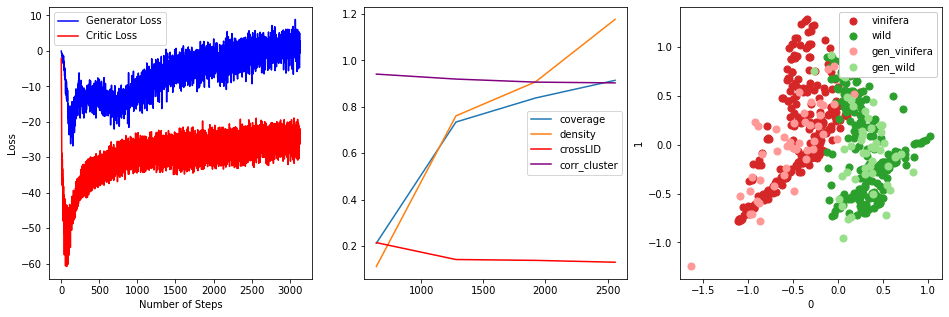

 25%|███████████████████                                                          | 3177/12800 [22:30<58:22,  2.75it/s]

In [ ]:
# Train models to generate samples for each fold
if GENERATE:
    generator_train = {}
    critic_train = {}

    results_train = {}

    for i in arti_train:
        generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

        df = arti_train[i][0]
        pca = PCA(n_components=2, svd_solver='full', whiten=True)
        pc_coords = pca.fit_transform(df)

        gen_loss_all = []
        crit_loss_all = []
        saved_predictions = []
        coverage = []
        density = []
        crossLID = []
        corr1stcluster = []

        generator_train[i] = generator_model(arti_train[i][0].shape[1], arti_train[i][0].shape[1], 256, 2)
        critic_train[i] = critic_model(arti_train[i][0].shape[1], 512, 2)

        training_montage(arti_train[i][0], arti_train[i][1], arti_train[i][0],arti_train[i][1],
                         800, generator_train[i], critic_train[i], generator_optimizer, critic_optimizer,
                         input_realdata_dist, batch_size, grad_pen_weight=5, k_cov_den=20, k_crossLID=15)

        results_train[i] = {'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'preds':saved_predictions,
                            'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1stcluster': corr1stcluster}

        #print(f'Fold {i} done.')

In [ ]:
# Save the models and results
import csv
if GENERATE:
    for i in generator_train:
        # Save the weigths of the models
        generator_train[i].save_weights('gan_models/vitis_gen_CV'+str(i))
        critic_train[i].save_weights('gan_models/vitis_crit_CV'+str(i))
        
    for i in generator_train:
        print(i)
        # Save the results of the models
        try:
            with open('gan_models/vitis_results_CV'+str(i)+'.csv', 'w') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=results_train[i].keys())
                writer.writeheader()
                writer.writerow(results_train[i])
        except IOError:
            print("I/O error")

In [ ]:
# Read back the models
#GENERATE = False
if not GENERATE:
    generator_train = {}
    critic_train = {}

    results_train = {}

    for i in arti_train:
        # Setting the model up
        generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
        critic_optimizer = tf.keras.optimizers.RMSprop(1e-4)

        generator_train[i] = generator_model(arti_train[i][0].shape[1], arti_train[i][0].shape[1], 256, 2)
        critic_train[i] = critic_model(arti_train[i][0].shape[1], 512, 2)

        # Load Previously saved models
        generator_train[i].load_weights('./gan_models/vitis_gen_CV'+str(i))
        critic_train[i].load_weights('./gan_models/vitis_crit_CV'+str(i))

#### Generate a lot of samples and make Random Forests and PLS-DA models

In [ ]:
np.random.seed(5407)
# Generate sample for each fold
generated_samples = {}

for i in generator_train:
    # Input to the generator
    num_examples_to_generate = 2048
    test_input = tf.constant(input_realdata_dist.rvs(size=len(arti_train[i][0].columns)*num_examples_to_generate), shape=[
        num_examples_to_generate,len(arti_train[i][0].columns)])
    test_labels = tf.constant([0]*(num_examples_to_generate//2) + [1]*(num_examples_to_generate//2), shape=[
            num_examples_to_generate,1])
    
    # Generate GAN samples
    predictions = generator_train[i]([test_input, test_labels], training=False)
    # Reverse the division done to the data
    predictions = predictions * 2* arti_train[i][0].values.std()
    
    generated_samples[i] = [pd.DataFrame(np.array(predictions), columns=arti_train[i][0].columns),
                            ['wild']*(num_examples_to_generate//2) + ['vinifera']*(num_examples_to_generate//2)]

Correlated GAN samples

In [ ]:
# To store for each fold
corr_generated_samples = {}

for i in generated_samples.keys():
    df = folds_train[i][0]
    # Calculate all correlations between all samples of real and artificial data and store them in a dataframe
    correlations = pd.DataFrame(index=generated_samples[i][0].index, columns=df.index).astype('float')

    for a in df.index:
        for j in generated_samples[i][0].index:
            correlations.loc[j,a] = stats.pearsonr(df.loc[a],
                                                   generated_samples[i][0].loc[j])[0]

    idx_to_keep = []
    for a in correlations:
        idx_to_keep.extend(correlations[a].sort_values(ascending=False).index[:5])
    
    print('Fold nº', i)
    print('Nº of total idx :', len(idx_to_keep))
    print('Nº of unique idx:', len(set(idx_to_keep)))

    corr_generated_samples[i] = [generated_samples[i][0].loc[list(set(idx_to_keep))], 
                                 list(np.array(generated_samples[i][1])[list(set(idx_to_keep))])]

Induced noise and intensity imputation samples

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
kf = StratifiedKFold(11, shuffle=True, random_state=7519)

# Make the folds
data_train = {}
noise_train = {}
a = 1

for train_index, test_index in kf.split(datasets['vitis_types']['BinSim'], datasets['vitis_types']['target']):
    #print(datasets['vitis_types']['BinSim'].iloc[train_index].copy())
    train_data = datasets['vitis_types']['BinSim'].iloc[train_index].copy()
    #grapevine_classes = train_data.index.get_level_values(0)
    train_lbls = list(np.array(datasets['vitis_types']['target'])[train_index])
    
    int_data = datasets['vitis_types']['data'].iloc[train_index].copy()
    int_lbls = np.array(datasets['vitis_types']['target'])[train_index]
    
    data_train[a] = [int_data, int_lbls]
    noise_train[a] = [train_data, train_lbls]
    
    a+=1

In [ ]:
# To store for each fold
noise_generated_samples = {}

for i in noise_train.keys():
    start = perf_counter()
    data_bin, lbls_bin = laf.artificial_dataset_generator(noise_train[i][0], labels=noise_train[i][1],
                                            max_new_samples_per_label=768, binary='random sampling', 
                                            rnd=list(np.linspace(0.1,0.9,9)), 
                                            binary_rnd_state=314, rnd_state=341)
    end = perf_counter()
    print(f'Simple augmentation of data done on fold {i}! took {(end - start):.3f} s')
    
    start = perf_counter()
    noise_df = data_bin.copy()
    for l in range(len(data_bin.index)):
        if lbls_bin[l] == 'wild':
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                data_bin.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = noise_train[i][0].loc[np.array(noise_train[i][1])=='wild'])
        else:
            noise_df.iloc[l] = laf.imbalanced_noise_inducer(
                data_bin.iloc[l], noise_fraction=0.10, method='random sampling', noise_fraction_changer=True,
                data = noise_train[i][0].loc[np.array(noise_train[i][1])=='vinifera'])
            
    res = noise_df.drop(columns=['554.26202'])
    norm = transf.normalize_ref_feature(data_train[i][0], 554.26202, remove=True)
    norm.columns = [str(l) for l in norm.columns]
    imputed_df = impute_intensity_values(res, norm,
                        labels=lbls_bin, orig_labels=data_train[i][1])
    
    imputed = transf.fillna_frac_min_feature(imputed_df, fraction=0.2)
    noise_generated_samples[i] = [transf.pareto_scale(transf.glog(imputed.astype(float))), lbls_bin]
    end = perf_counter()
    print(f'Noise Induced and Imputation augmentation of data done on fold {i}! took {(end - start):.3f} s')

Random Forests

In [ ]:
# Fitting and storing Random Forest models for each fold for real, GAN and CorrGAN Data
RF_models_gen = {}
RF_models_real = {}
RF_models_corr = {}
RF_models_noise = {}

# Train the Models with real or GAN generated Data
for i in generated_samples:
    rf_mod = ma.RF_model(generated_samples[i][0], generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_gen[i] = rf_mod
    
    rf_mod = ma.RF_model(folds_train[i][0], folds_train[i][1], return_cv=False, n_trees=200)
    RF_models_real[i] = rf_mod
    
    rf_mod = ma.RF_model(corr_generated_samples[i][0], corr_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_corr[i] = rf_mod
    
    rf_mod = ma.RF_model(corr_generated_samples[i][0], corr_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_corr[i] = rf_mod
    
    rf_mod = ma.RF_model(noise_generated_samples[i][0], noise_generated_samples[i][1], return_cv=False, n_trees=200)
    RF_models_noise[i] = rf_mod

In [ ]:
# Testing the RF models with the test data for each fold for real, GAN and CorrGAN Data
RF_results_gen = {}
RF_results_real = {}
RF_results_corr = {}
RF_results_noise = {}

# Test the models
for i in RF_models_gen:
    RF_results_gen[i] = RF_models_gen[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_real[i] = RF_models_real[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_corr[i] = RF_models_corr[i].score(folds_test[i][0], folds_test[i][1])
    
    RF_results_noise[i] = RF_models_noise[i].score(folds_test[i][0], folds_test[i][1])

In [ ]:
# See average accuracies
print('GAN Samples Model Average Accuracy:           ', np.array(list(RF_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(RF_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(RF_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(RF_results_real.values())).mean()*100, '%.')

PLS-DA models

In [ ]:
from sklearn.cross_decomposition import PLSRegression
def fit_PLSDA_model(data, labels, unique_labels, n_comp=10, scale=False, encode2as1vector=True):
    "Fit a PLSRegression model."
    
    # create label lists
    is1vector = (len(unique_labels) == 2) and encode2as1vector

    # Generate the response variable Y for PLSRegression
    target = ma._generate_y_PLSDA(labels, unique_labels, is1vector)

    plsda = PLSRegression(n_components=n_comp, scale=scale)
    # Fitting the model
    plsda.fit(X=data,Y=target)
    
    return plsda

In [ ]:
def decision_rule(y_pred, y_true):
    # Decision rule for classification
    # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
    # In case of 1,0 encoding for two groups, round to nearest integer to compare
    nright = 0
    rounded = np.round(y_pred)

    for p in range(len(y_pred)):
        if rounded[p] >= 1:
            pred = 1
        else:
            pred = 0
        if pred == y_true[p]:
            nright += 1  # Correct prediction


    # Calculate accuracy for this iteration
    accuracy = (nright / len(y_pred))
    return accuracy

In [ ]:
np.random.seed(5407)

PLSDA_results_gen = {}
PLSDA_results_real = {}
PLSDA_results_corr = {}
PLSDA_results_noise = {}

# Train and test the models
for i in generated_samples:
    
    # GAN Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    generated_samples[i][0], generated_samples[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = fit_PLSDA_model(generated_samples[i][0], generated_samples[i][1], pd.unique(generated_samples[i][1]), n_comp=4,
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(generated_samples[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_gen[i] = accuracy
    
    # Real Data models
    #optim_pls = ma.optim_PLSDA_n_components(
    #    folds_train[i][0], folds_train[i][1], encode2as1vector=True, max_comp=20, n_fold=5).CVscores
    #print(np.array(optim_pls).argmax() + 1, np.array(optim_pls).max())
    plsda = fit_PLSDA_model(folds_train[i][0], folds_train[i][1], pd.unique(folds_train[i][1]), n_comp=4,
                    scale=False, encode2as1vector=True)
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(folds_train[i][1]), True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_real[i] = accuracy

    # CorrGAN Data models
    plsda = fit_PLSDA_model(corr_generated_samples[i][0], corr_generated_samples[i][1],
                            pd.unique(corr_generated_samples[i][1]), n_comp=4,
                                              scale=False, encode2as1vector=True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(corr_generated_samples[i][1]), True)
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_corr[i] = accuracy
    
    # Noise Induced and Imputed Data models
    plsda = ma.fit_PLSDA_model(noise_generated_samples[i][0], noise_generated_samples[i][1], n_comp=4,
                                              return_scores=False, scale=False, encode2as1vector=True)
    # Obtain results with the test group
    y_pred = plsda.predict(folds_test[i][0])
    y_true = ma._generate_y_PLSDA(folds_test[i][1], pd.unique(noise_generated_samples[i][1]), True)
    # Calculate accuracy
    accuracy = decision_rule(y_pred, y_true)
    PLSDA_results_noise[i] = accuracy                  

In [ ]:
print('GAN Samples Model Average Accuracy:           ', np.array(list(PLSDA_results_gen.values())).mean()*100, '%.')
print('Correlated GAN Samples Model Average Accuracy:', np.array(list(PLSDA_results_corr.values())).mean()*100, '%.')
print('Noise Induced Samples Model Average Accuracy: ', np.array(list(PLSDA_results_noise.values())).mean()*100, '%.')
print('Real Samples Model Average Accuracy:          ', np.array(list(PLSDA_results_real.values())).mean()*100, '%.')

Deep Learning methodology

In [ ]:
def deep_classifier(len_input):
    
    classifier = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, use_bias=True, input_shape=(len_input,)),
        tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu, use_bias=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax', use_bias=True)])
    
    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classifier

In [ ]:
# To store loss and accuracies of deep learning model
dl_loss_gen = {}
dl_loss_real = {}
dl_loss_corr = {}
dl_loss_noise = {}

dl_losstest_gen = {}
dl_losstest_real = {}
dl_losstest_corr = {}
dl_losstest_noise = {}

dl_results_gen = {}
dl_results_real = {}
dl_results_corr = {}
dl_results_noise = {}

for i in generated_samples:
    # GAN Model
    deep_class = deep_classifier(len(generated_samples[i][0].columns))
    model = deep_class.fit(generated_samples[i][0].values, 
                           pd.get_dummies(generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_gen[i] = model.history['loss']
    
    dl_losstest_gen[i], dl_results_gen[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    

    # CorrGAN Model
    deep_class = deep_classifier(len(corr_generated_samples[i][0].columns))
    model = deep_class.fit(corr_generated_samples[i][0].values, 
                           pd.get_dummies(corr_generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_corr[i] = model.history['loss']
    
    dl_losstest_corr[i], dl_results_corr[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    
    # Noise Induced and Imputed Intensity Model
    deep_class = deep_classifier(len(noise_generated_samples[i][0].columns))
    model = deep_class.fit(noise_generated_samples[i][0].values, 
                           pd.get_dummies(noise_generated_samples[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_noise[i] = model.history['loss']
    
    dl_losstest_noise[i], dl_results_noise[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    
    # Real Model
    deep_class = deep_classifier(len(folds_train[i][0].columns))
    model = deep_class.fit(folds_train[i][0].values, 
                           pd.get_dummies(folds_train[i][1])[['vinifera', 'wild']], epochs = 100, 
                           batch_size=32,
                           validation_data=(folds_test[i][0].values, 
                                            pd.get_dummies(folds_test[i][1])[['vinifera', 'wild']]))
    dl_loss_real[i] = model.history['loss']
    
    dl_losstest_real[i], dl_results_real[i] = deep_class.evaluate(folds_test[i][0].values, pd.get_dummies(folds_test[i][1]))
    
    print(f'Fold {i} done!')

In [ ]:
f, (axl, axc, axr) = plt.subplots(1,3,figsize=(16,6))
epochs=100
# Graph depicting deep learning model Loss
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_gen).mean(axis=1), label = 'GAN Data', color='Red')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_corr).mean(axis=1), label = 'CorrGAN Data', color='Green')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_noise).mean(axis=1), label = 'Noise I. Data', color='Black')
axl.scatter(range(1,epochs+1), pd.DataFrame(dl_loss_real).mean(axis=1), label = 'Real Data', color='Blue')
axl.legend(loc='upper left', fontsize=13)
axl.set_xlabel('Training Set Loss', fontsize=15)
axl.set_ylabel('Epochs', fontsize=15)

# Graph depicting deep learning model Loss of the test set
axc.bar(['GAN Data', 'CorrGan Data', 'Noise Induced Data', 'Real Data'],
    [np.mean(list(dl_losstest_gen.values())), np.mean(list(dl_losstest_corr.values())), 
     np.mean(list(dl_losstest_noise.values())), np.mean(list(dl_losstest_real.values()))],
            color=['red', 'green', 'black', 'blue'])
axc.set_ylabel('Test Set Loss', fontsize=15)

# Deep Learning model accuracy on predicting the test set class
axr.bar(['GAN Data', 'CorrGan Data', 'Noise Induced Data', 'Real Data'],
    [np.mean(list(dl_results_gen.values())), np.mean(list(dl_results_corr.values())), 
     np.mean(list(dl_results_noise.values())), np.mean(list(dl_results_real.values()))],
            color=['red', 'green', 'black', 'blue'])
axr.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()
plt.show()

#### Overall Results

In [ ]:
# Results
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.5):
        f, axu = plt.subplots(1, 1, figsize=(3.5, 6), constrained_layout=True)
        x = np.arange(3)  # the label locations
        labels = ['RF', 'PLSDA', 'DNN']
        width = 0.19  # the width of the bars
        
        offset = - 0.3 + 0 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_gen.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_gen.values())).mean()*100,
                                                            np.array(list(dl_results_gen.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_gen.values())).std()*100, 
                                             np.array(list(PLSDA_results_gen.values())).std()*100,
                                             np.array(list(dl_results_gen.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='GAN data', color='red')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 1 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_corr.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_corr.values())).mean()*100,
                                                            np.array(list(dl_results_corr.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_corr.values())).std()*100, 
                                             np.array(list(PLSDA_results_corr.values())).std()*100,
                                             np.array(list(dl_results_corr.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='CorrGAN data', color='green')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 2 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_noise.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_noise.values())).mean()*100,
                                                            np.array(list(dl_results_noise.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_noise.values())).std()*100, 
                                             np.array(list(PLSDA_results_noise.values())).std()*100,
                                             np.array(list(dl_results_noise.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'],
                        width, label='Noise I. data', color='black')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
        #                ls='none', ecolor='0.2', capsize=3)
        
        offset = - 0.3 + 3 * 0.2
        accuracy_stats = pd.DataFrame({'Average accuracy': [np.array(list(RF_results_real.values())).mean()*100, 
                                                            np.array(list(PLSDA_results_real.values())).mean()*100,
                                                            np.array(list(dl_results_real.values())).mean()*100],
                                     'STD': [np.array(list(RF_results_real.values())).std()*100, 
                                             np.array(list(PLSDA_results_real.values())).std()*100,
                                             np.array(list(dl_results_real.values())).std()*100]})
        rects = axu.bar(x + offset, accuracy_stats['Average accuracy'], width, label='Real data', color='blue')
        #axu.errorbar(x + offset, y=accuracy_stats['Average accuracy'], yerr=accuracy_stats['STD'],
         #               ls='none', ecolor='0.2', capsize=3)
        
        axu.set_xticks(x)
        axu.set_xticklabels(labels, fontsize=14)
        axu.set(ylabel='Average accuracy (%)', title='', ylim=(20,105))
        for spine in axu.spines.values():
            spine.set_edgecolor('0.1')
        
        axu.legend(loc='lower right', fontsize=14, ncol=1)
        #plt.title('Cross-Validation', fontsize=17)
        plt.show()
        f.savefig('images/GD_AccuPlot.png' , dpi=300)

### Optimizing with different parameters

In [ ]:
# Testing different learning rates
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}

results = {}
generators = {}

for i, lr in test_lrs.items():
    
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []
    
    generator_optimizer = tf.keras.optimizers.RMSprop(lr)
    critic_optimizer = tf.keras.optimizers.RMSprop(lr)

    generator[i] = generator_model(data_NGP.shape[1], data_NGP.shape[1], 256, 2)
    critic = critic_model(data_NGP.shape[1], 256, 2)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_NGP, lbls, data_NGP, lbls, 1000, generator[i], critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)
    
    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
# Testing different optimizers
test_lrs = {1: 1e-5, 2:5e-5, 3: 1e-4, 4:5e-4, 5: 1e-3, 6:5e-3}
test_opts = {1: tf.keras.optimizers.RMSprop(5e-5), 2:tf.keras.optimizers.Adadelta(5e-5),
             3: tf.keras.optimizers.Adam(5e-5), 4:tf.keras.optimizers.SGD(5e-5),
             5: tf.keras.optimizers.Ftrl(5e-5)}

results = {}
generators = {}

for i, opt in test_opts.items():

    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []

    generator_optimizer = opt
    critic_optimizer = opt

    generator[i] = generator_model(data_NGP.shape[1], data_NGP.shape[1], 256, 2)
    critic = critic_model(data_NGP.shape[1], 256, 2)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_NGP, lbls, data_NGP, lbls,1000, generator[i], critic, generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=20, k_crossLID=15)
    
    results[i]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all, 'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}

In [ ]:
# Testing different combinations of nodes in the hidden layer
import itertools
results = {}
generators = {}

n_hidden_nodes = [256, 512, 1024]
for n_hidden_gen, n_hidden_critic in itertools.product(n_hidden_nodes, n_hidden_nodes):
    
    gen_loss_all = []
    crit_loss_all = []
    saved_predictions = []
    accuracy = []
    coverage = []
    density = []
    crossLID = []
    corr1stcluster = []
    
    generator_optimizer = tf.keras.optimizers.RMSprop(5e-3)
    critic_optimizer = tf.keras.optimizers.RMSprop(5e-3)

    generator[(n_hidden_gen, n_hidden_critic)] = generator_model(data_NGP.shape[1], data_NGP.shape[1], n_hidden_gen, 2)
    critic = critic_model(data_NGP.shape[1], n_hidden_critic, 2)
    #gan = gan_model(generator, critic, generator_optimizer)

    training_montage(data_NGP, lbls, data_NGP, lbls, 1000, generator[(n_hidden_gen, n_hidden_critic)], critic, 
                     generator_optimizer, critic_optimizer,
                     input_realdata_dist, batch_size, grad_pen_weight=10, k_cov_den=50, k_crossLID=15)
    
    results[(n_hidden_gen, n_hidden_critic)]={'gen_loss': gen_loss_all, 'crit_loss': crit_loss_all,
                'saved_pred': saved_predictions,
                'coverage': coverage, 'density': density, 'crossLID': crossLID, 'corr1st_cluster': corr1stcluster}